# Chapter 3: Generative Adversarial Networks (GANs): Shape and Pattern Generation




***
“Adversarial training (also called GAN for Generative Adversarial Networks), and the variations that are now being proposed, is the most interesting idea in the last 10 years in ML, in my opinion.”


-- Yann LeCun 
***



This chapter covers
* Creating a generator network and a discriminator network in GANs from scratch 
* Using GANs to generate data points to form shapes 
* Generating a sequence of integers that are all multiples of five
* Learning how to train, save, reload, and use GANs
* Assessing the performance of GANs and deciding when to stop training

Close to half of the generative models in this book belong to a framework called Generative Adversarial Networks (GANs). The framework was first proposed by Ian Goodfellow and his coauthors in 2014. GANs, celebrated for their ease of implementation and versatility, empower individuals with even rudimentary knowledge of deep learning to construct their models from the ground up. The word "adversarial" in GAN refers to the fact that the two neural networks compete against each other in a zero-sum game framework: the generative network tries to create data instances indistinguishable from real samples, while the discriminative network tries to identify the generated samples from real ones. These versatile models can give rise to a plethora of creations, from geometric shapes and intricate patterns to high-quality color images like human faces, and even realistic-sounding musical compositions. 

In this chapter, I'll briefly review the theory behind Generative Adversarial Networks. Then, I'll show you how to implement that knowledge in PyTorch. You'll learn to build your first GAN from scratch so that all the details are demystified. To make the example relatable, imagine you put $1 in a savings account that pays 8 percent a year. You want to find out the balance in your account based on the number of years you have invested. The true relation is an exponential growth curve. You'll learn to use GANs to generate data samples, pairs of values (x, y), that form an exponential growth curve. Armed with this skill, you'll be able to generate data to mimic any shape: sine, cosine, quadratic, and so on. 

In the second project in this chapter, you’ll learn how to use GANs to generate a sequence of numbers that are all multiples of five. But you can change the pattern to multiples of two, three, seven, …, or other patterns. Along the way, you’ll learn how to create a generator network and a discriminator network from scratch. You’ll learn how to train, save, and use GANs. Further, you’ll also learn to assess the performance of GANs either by visualizing samples generated by the generator network, or by measuring the divergence between the generated sample distribution and the real data distribution. 
In later chapters, you will build on the fundamental GAN architecture you learned here to generate other content such as high-resolution images and realistic-sounding music.

# 1.  Steps Involved in Training GANs 

# 2. Preparing Training Data
## 2.1 A Training Dataset that Forms An Exponential Growth Shape

In [1]:
import torch

torch.manual_seed(42)    #A

train_data = torch.zeros((2048, 2))    #B 

train_data[:,0]=50*torch.rand(2048)    #C

train_data[:,1]=1.08**train_data[:,0]    #D

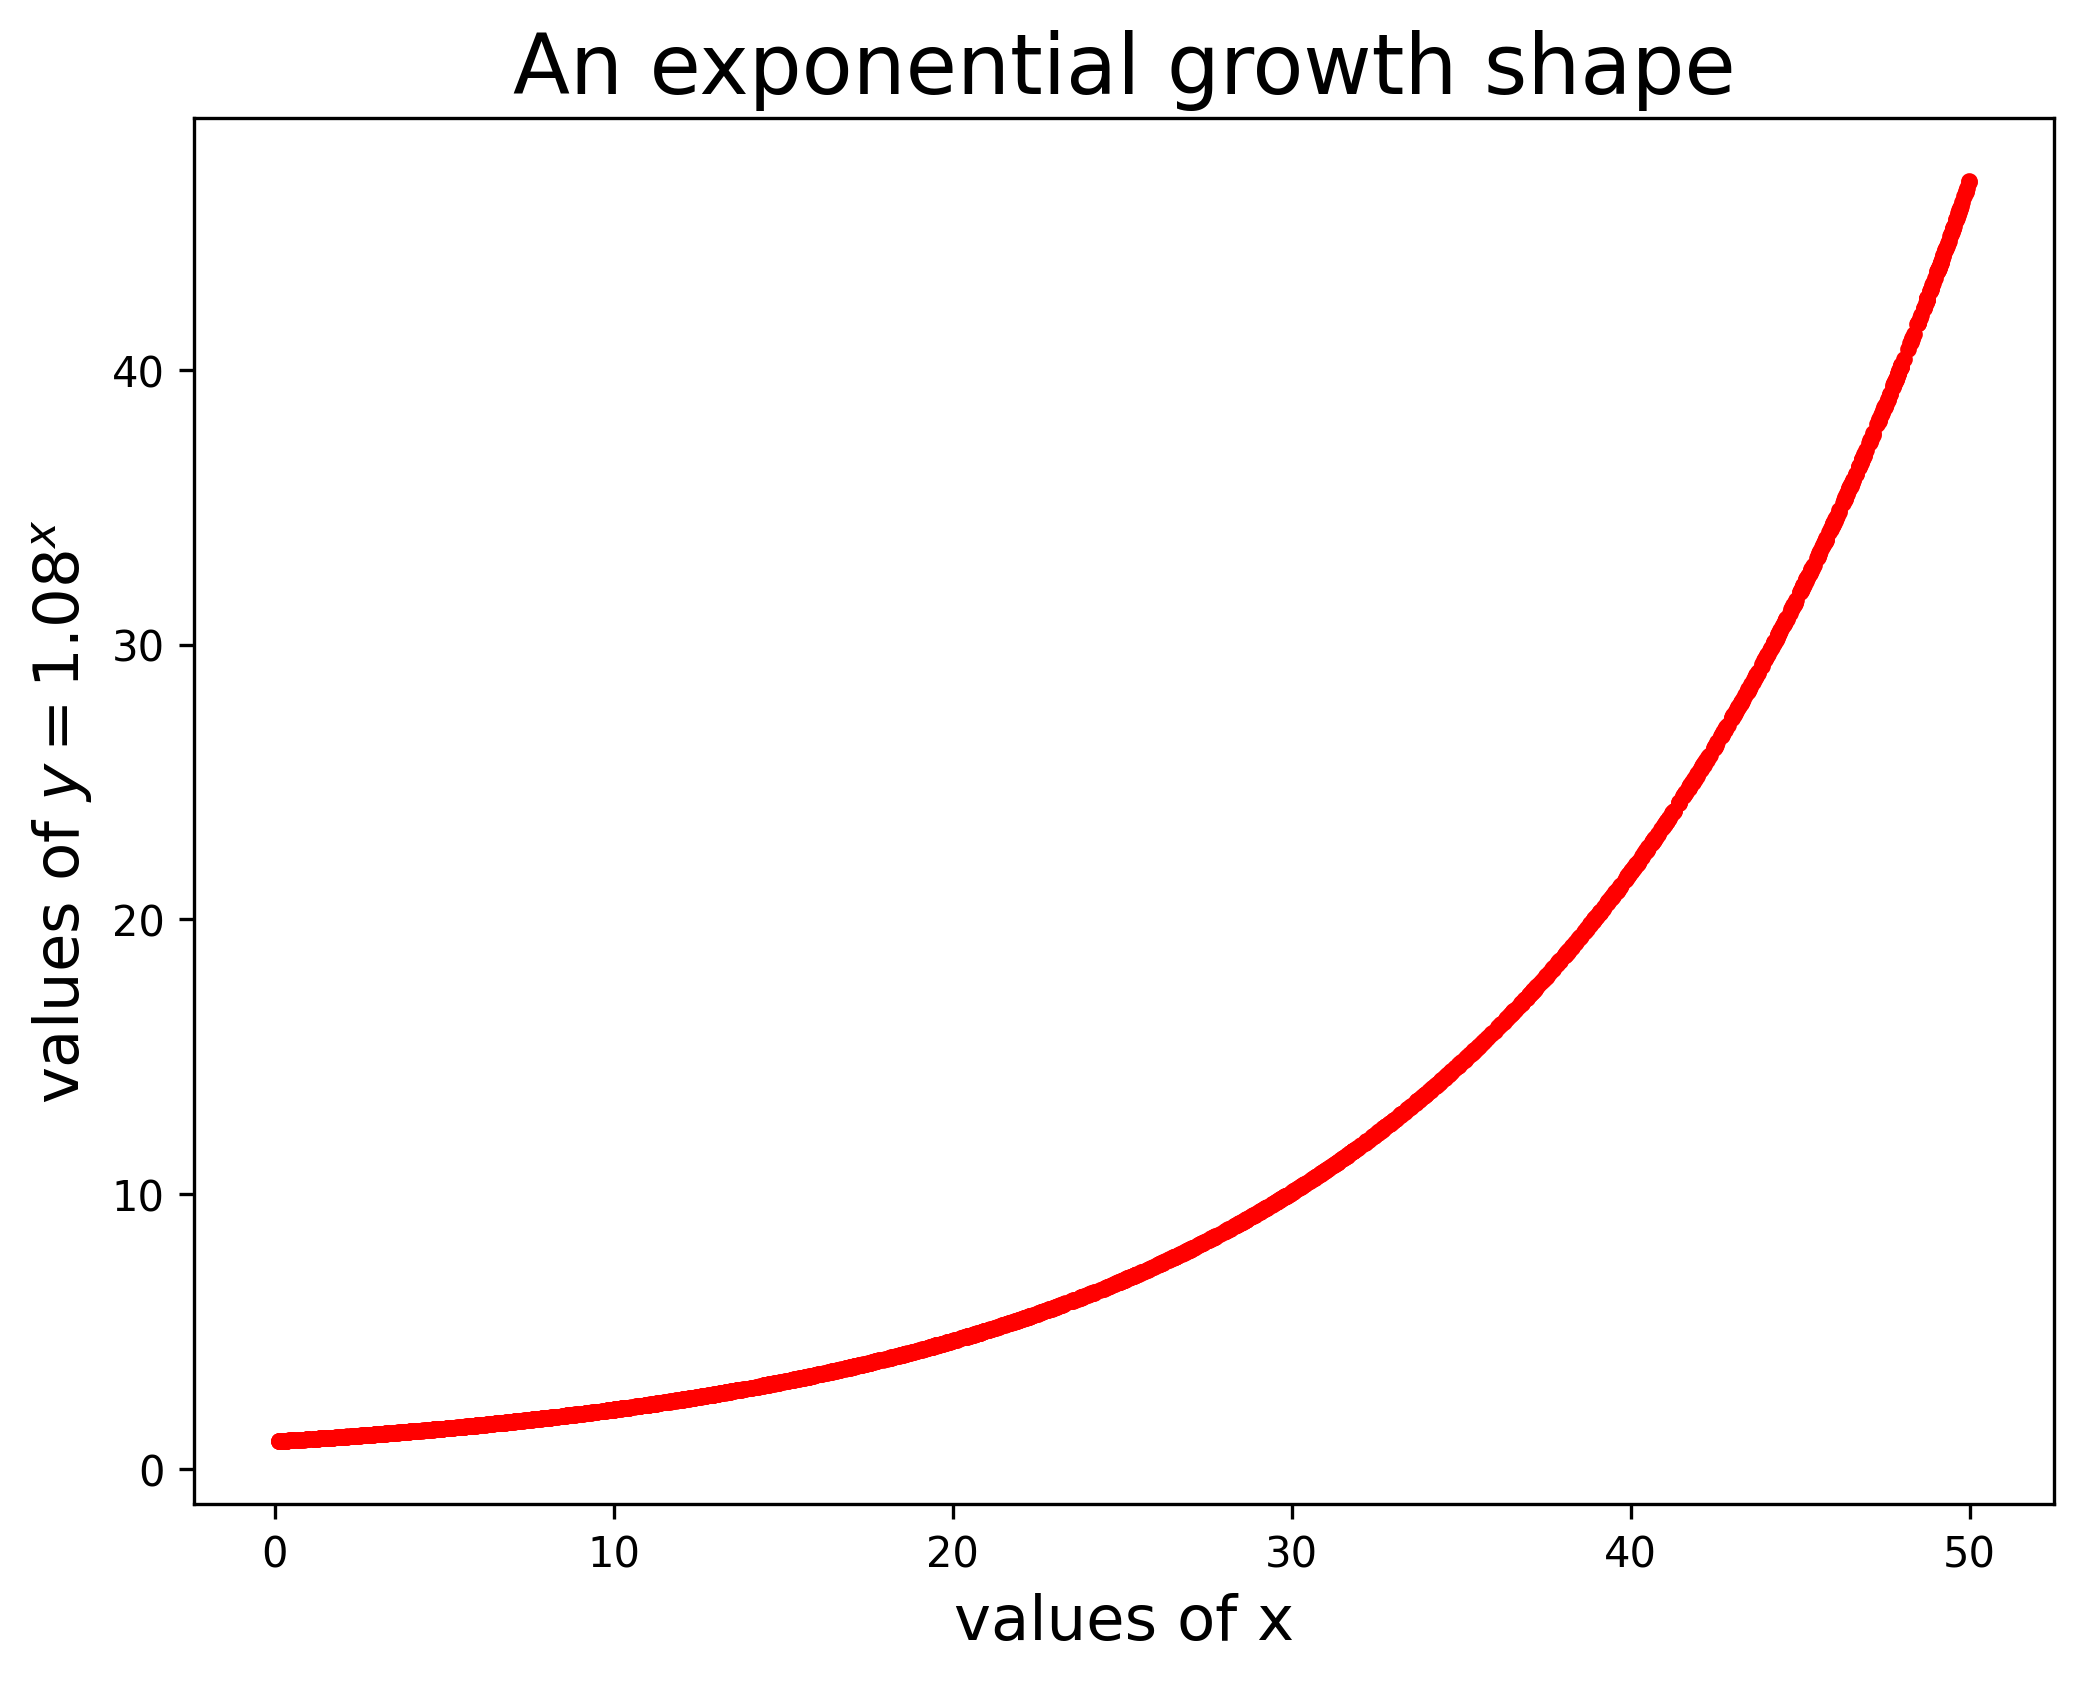

In [2]:
import matplotlib.pyplot as plt

fig=plt.figure(dpi=300,figsize=(8,6))
plt.plot(train_data[:,0],train_data[:,1],".",c="r")    #A
plt.xlabel("values of x",fontsize=15)
plt.ylabel("values of $y=1.08^x$",fontsize=15)    #B
plt.title("An exponential growth shape",fontsize=20)    #C
plt.show()

## 2.2. Preparing the Training Dataset

In [3]:
from torch.utils.data import DataLoader

batch_size=128
train_loader=DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True)

In [4]:
batch0=next(iter(train_loader))
print(batch0)

tensor([[32.8580, 12.5383],
        [49.5096, 45.1644],
        [22.1537,  5.5012],
        [ 2.6772,  1.2288],
        [39.6123, 21.0858],
        [47.3162, 38.1494],
        [30.3857, 10.3659],
        [12.6040,  2.6380],
        [38.7219, 19.6894],
        [24.6551,  6.6691],
        [43.9691, 29.4859],
        [ 2.6108,  1.2225],
        [49.3744, 44.6970],
        [48.3075, 41.1736],
        [39.9140, 21.5813],
        [41.8250, 25.0006],
        [33.4426, 13.1153],
        [12.0894,  2.5356],
        [15.5622,  3.3124],
        [39.0050, 20.1231],
        [47.9834, 40.1594],
        [12.5158,  2.6201],
        [ 1.7145,  1.1410],
        [15.7433,  3.3589],
        [34.3105, 14.0212],
        [21.7548,  5.3349],
        [26.1978,  7.5098],
        [12.7987,  2.6778],
        [ 5.5772,  1.5361],
        [10.7664,  2.2901],
        [11.6135,  2.4444],
        [31.8176, 11.5735],
        [27.3596,  8.2122],
        [37.3611, 17.7317],
        [28.5974,  9.0330],
        [28.0962,  8

## 2.3. Creating Generative Adversarial Networks (GANs)

In [5]:
import torch.nn as nn

device="cuda" if torch.cuda.is_available() else "cpu"

D=nn.Sequential(
    nn.Linear(2,256),    #A
    nn.ReLU(),
    nn.Dropout(0.3),    #B
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64,1),    #C
    nn.Sigmoid()).to(device)

In [6]:
G=nn.Sequential(
    nn.Linear(2,16),    #A
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU(),
    nn.Linear(32,2)).to(device)    #B

In [7]:
loss_fn=nn.BCELoss()
lr=0.0005
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

In [8]:
mse=nn.MSELoss()    #A

def performance(fake_samples):
    real=1.08**fake_samples[:,0]    #B
    mseloss=mse(fake_samples[:,1],real)   #C
    return mseloss

In [9]:
class EarlyStop:
    def __init__(self, patience=1000):    #A
        self.patience = patience
        self.steps = 0
        self.min_gdif = float('inf')
    def stop(self, gdif):    #B
        if gdif < self.min_gdif:    #C
            self.min_gdif = gdif
            self.steps = 0
        elif gdif >= self.min_gdif:
            self.steps += 1
        if self.steps >= self.patience:    #D
            return True
        else:
            return False
stopper=EarlyStop()

# 3. Train and Use GANs for Shape Generation

## 3.1. Train the GANs

In [10]:
real_labels=torch.ones((batch_size,1))
real_labels=real_labels.to(device)

fake_labels=torch.zeros((batch_size,1))
fake_labels=fake_labels.to(device)

In [11]:
def train_D_on_real(real_samples):
    real_samples=real_samples.to(device)
    optimD.zero_grad()
    out_D=D(real_samples)    #A
    loss_D=loss_fn(out_D,real_labels)    #B
    loss_D.backward()
    optimD.step()    #C
    return loss_D

In [12]:
def train_D_on_fake():        
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    fake_samples=G(noise)     #A       
    optimD.zero_grad()
    out_D=D(fake_samples)    #B
    loss_D=loss_fn(out_D,fake_labels)    #C
    loss_D.backward()
    optimD.step()    #D
    return loss_D

In [13]:
def train_G(): 
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    optimG.zero_grad()
    fake_samples=G(noise)    #A
    out_G=D(fake_samples)    #B
    loss_G=loss_fn(out_G,real_labels)    #C
    loss_G.backward()
    optimG.step()     #D
    return loss_G, fake_samples 

In [14]:
import os
os.makedirs("files", exist_ok=True)    #A

def test_epoch(epoch,gloss,dloss,n):
    if epoch==0 or (epoch+1)%25==0:
        g=gloss.item()/n
        d=dloss.item()/n
        print(f"at epoch {epoch}, G loss: {g}, D loss {d}")    #B 
        fake=fake_samples.detach().cpu().numpy()
        plt.figure(dpi=200)
        plt.plot(fake[:,0],fake[:,1],"*",c="g",
            label="generated samples")    #C
        plt.plot(train_data[:,0],train_data[:,1],".",c="r",
            alpha=0.1,label="real samples")    #D
        plt.title(f"epoch {epoch+1}")
        plt.xlim(0,50)
        plt.ylim(0,50)
        plt.legend()
        plt.savefig(f"files/p{epoch+1}.png")
        plt.show()

at epoch 0, G loss: 0.711500612894694, D loss 1.049901262919108


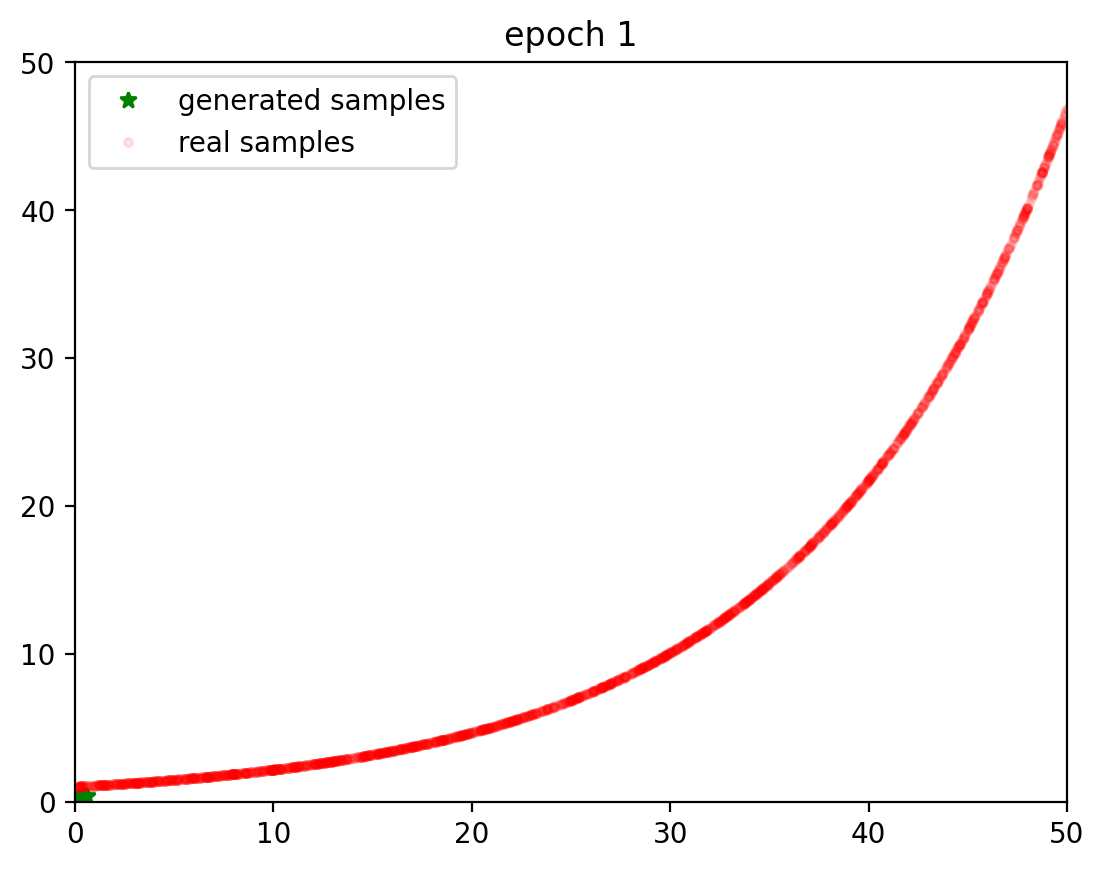

at epoch 24, G loss: 1.7289756774902343, D loss 0.7733614603678386


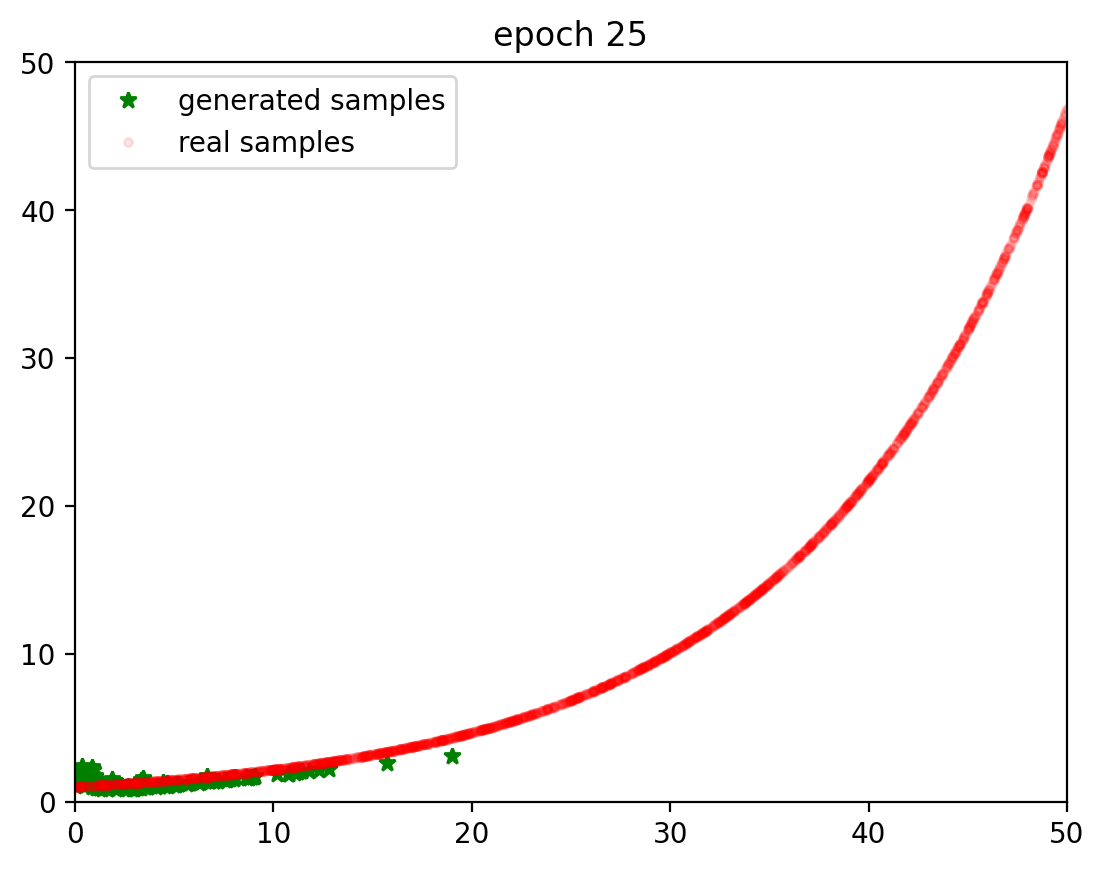

at epoch 49, G loss: 1.2084575653076173, D loss 1.0271043141682943


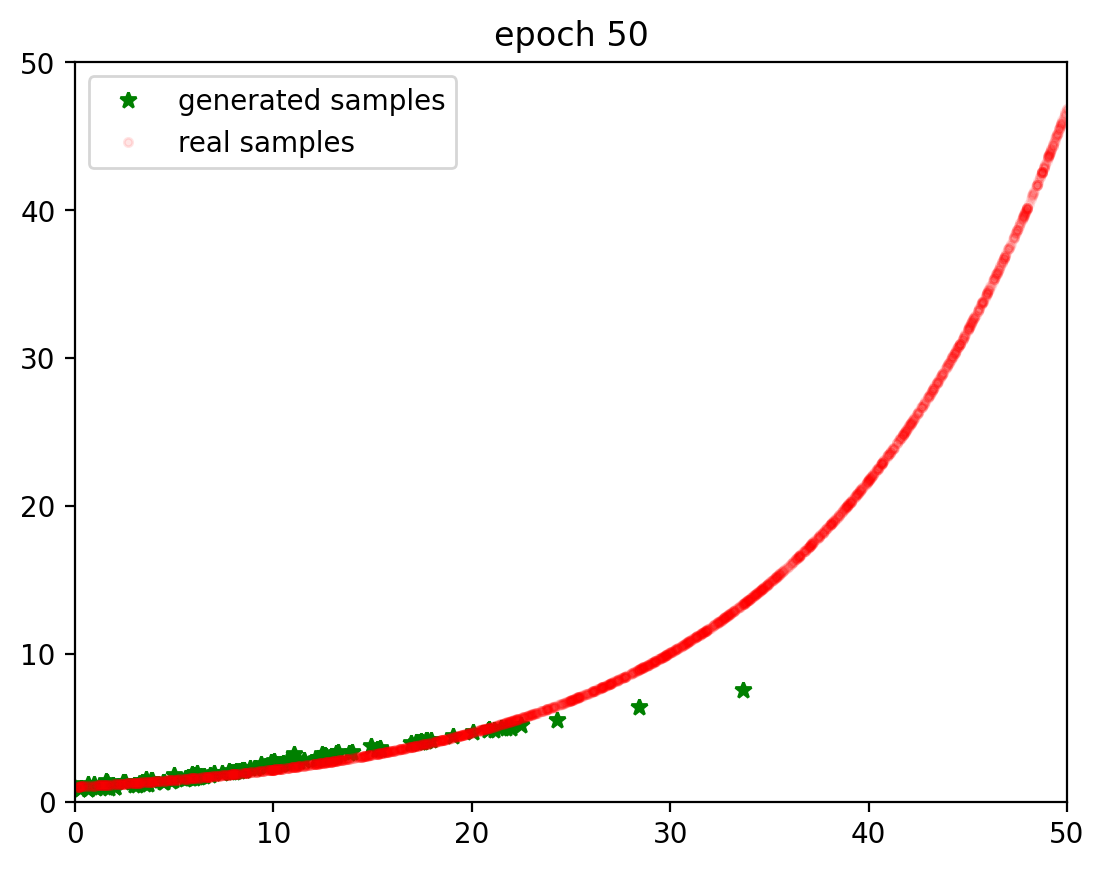

at epoch 74, G loss: 1.079989751180013, D loss 1.1690965016682944


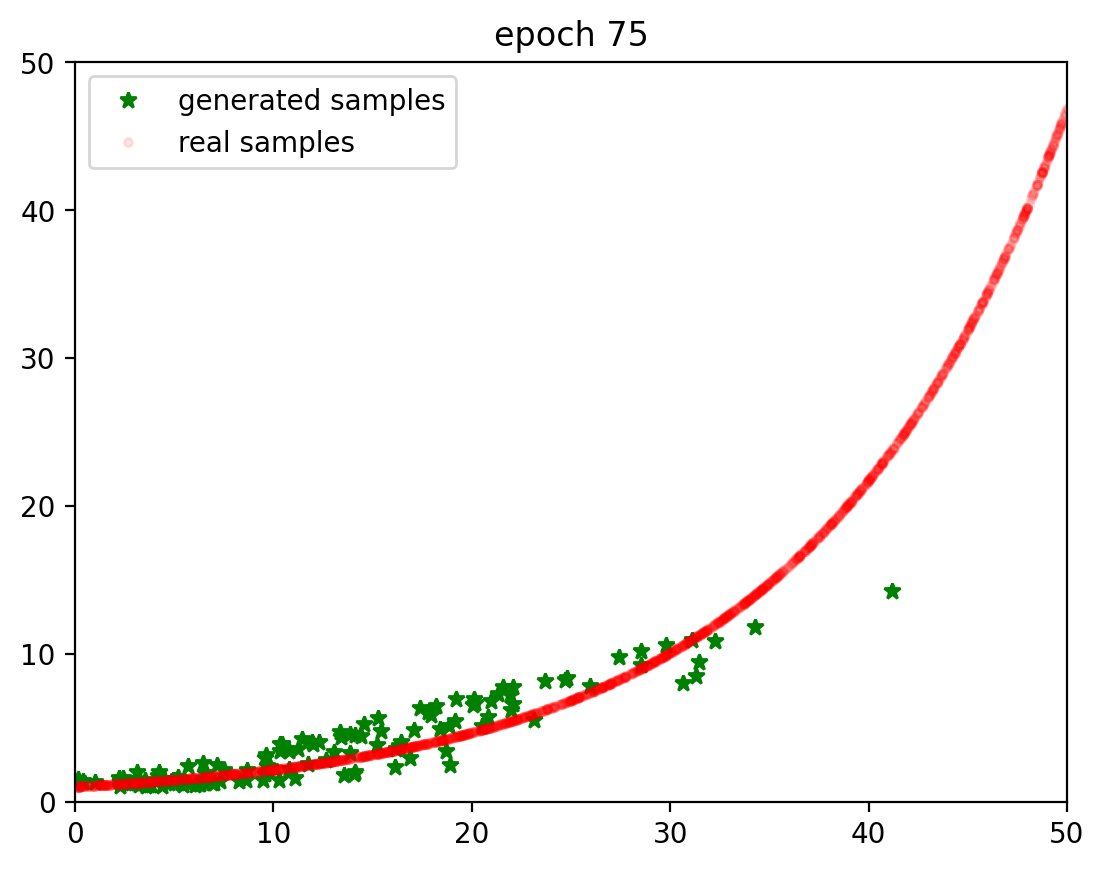

at epoch 99, G loss: 1.0022057215372722, D loss 1.211972173055013


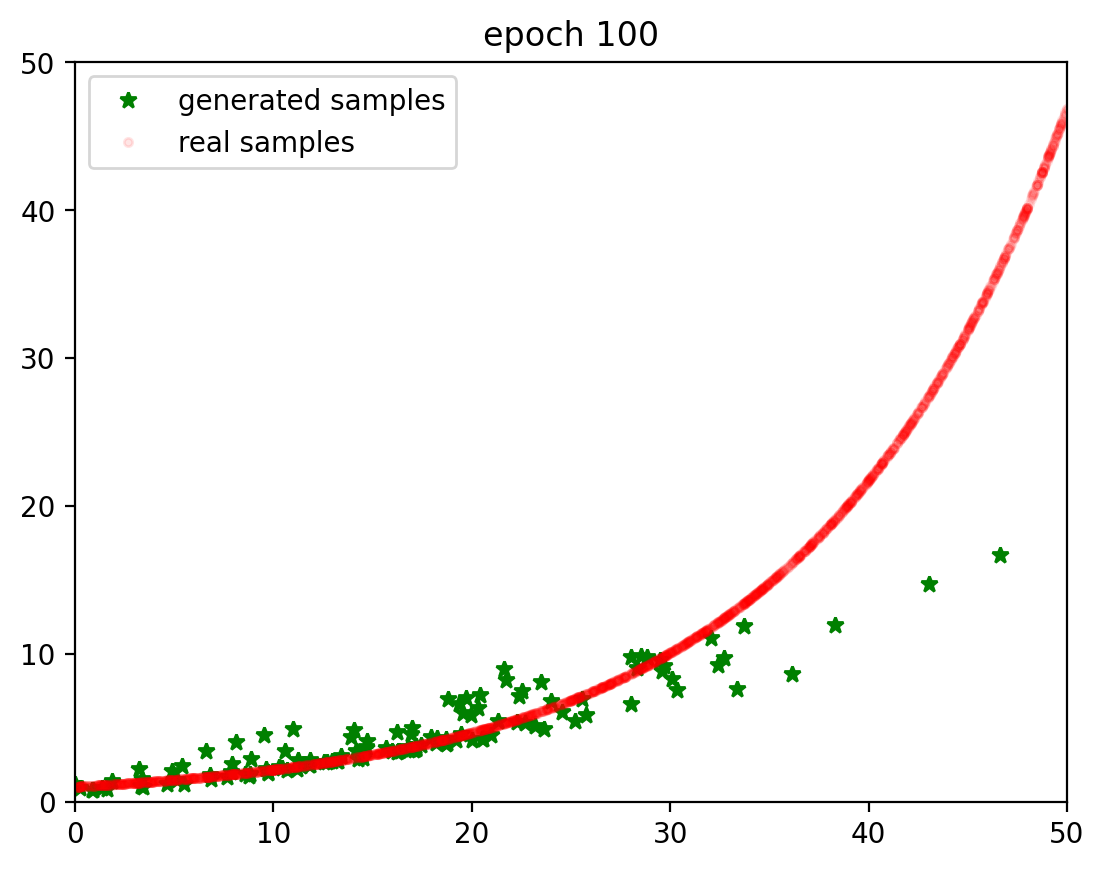

at epoch 124, G loss: 0.9672571818033854, D loss 1.2461043039957682


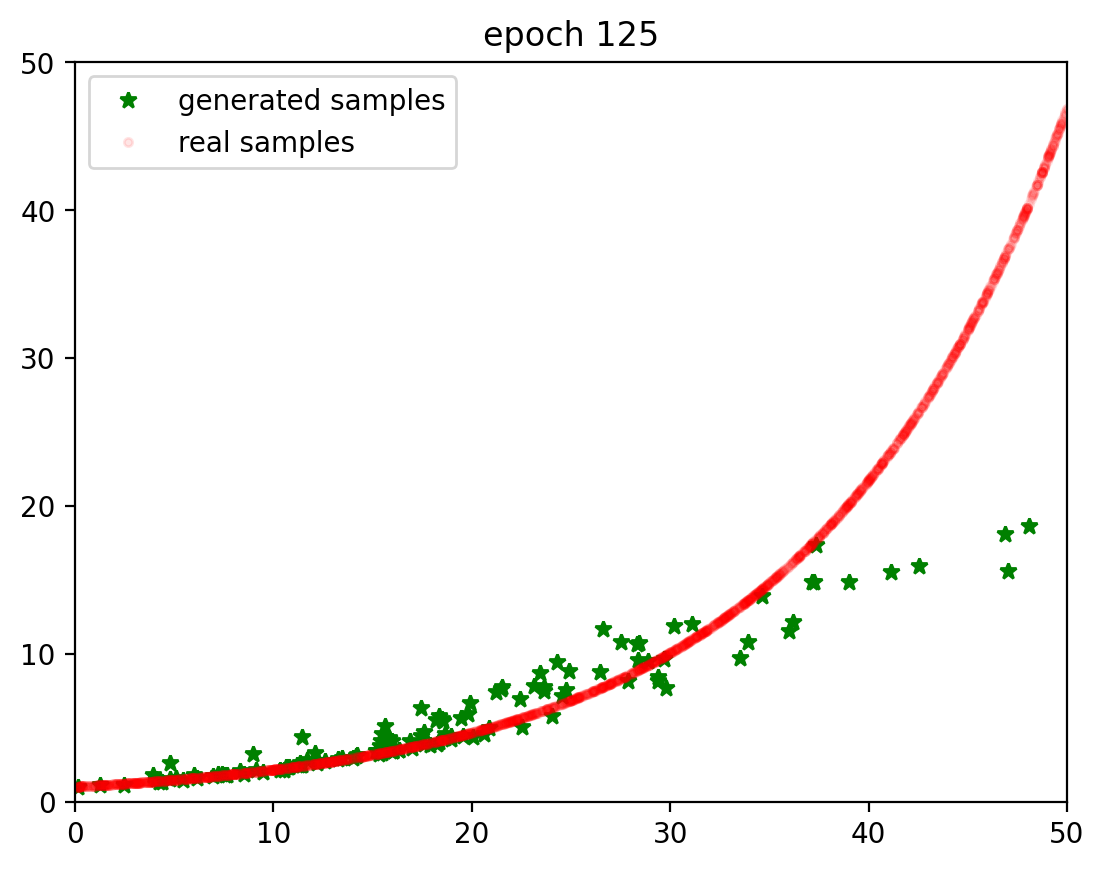

at epoch 149, G loss: 0.9146135330200196, D loss 1.2956658681233724


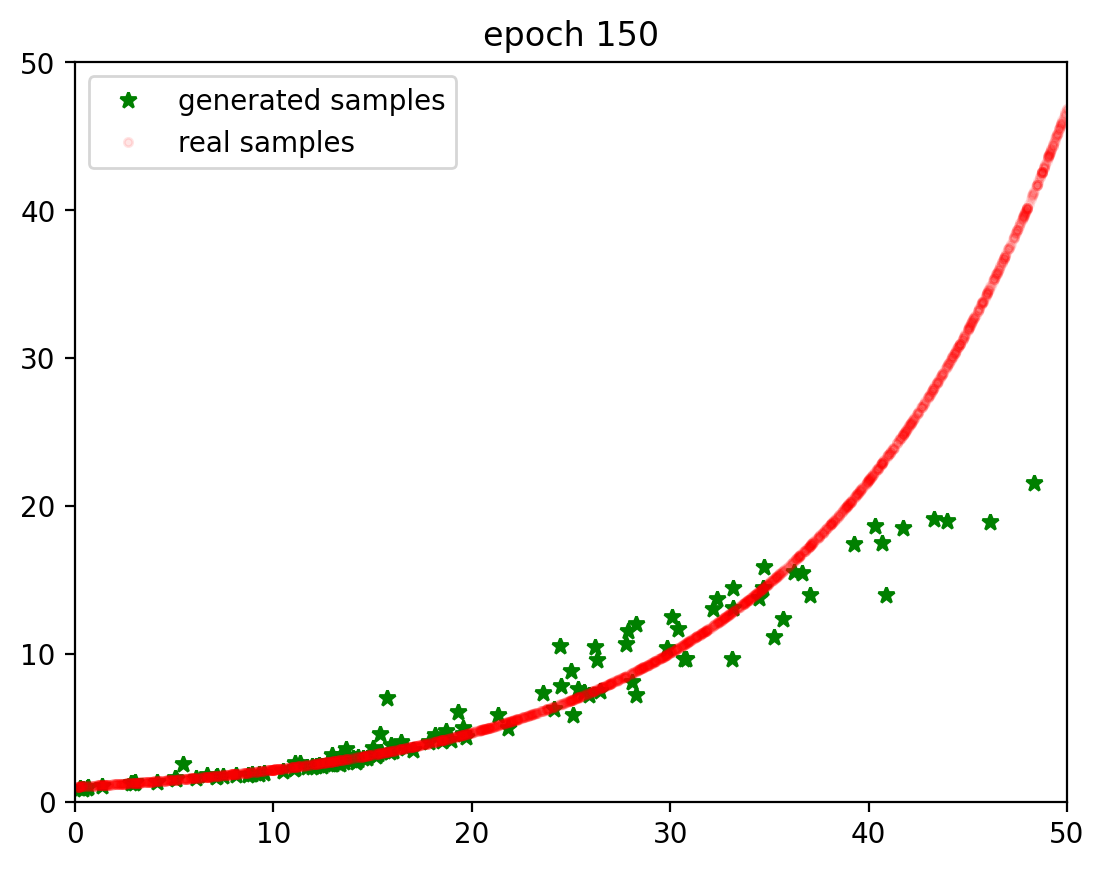

at epoch 174, G loss: 0.8440717061360677, D loss 1.3530502319335938


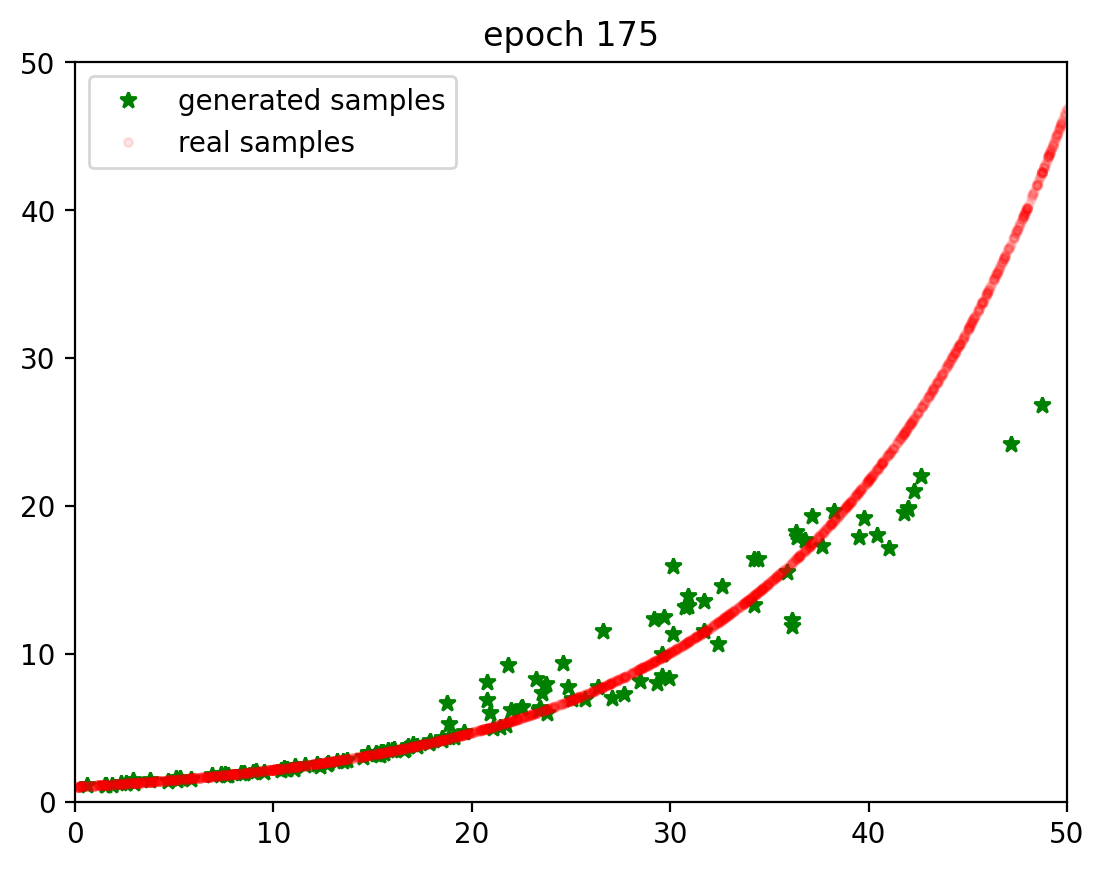

at epoch 199, G loss: 0.7991668701171875, D loss 1.397433344523112


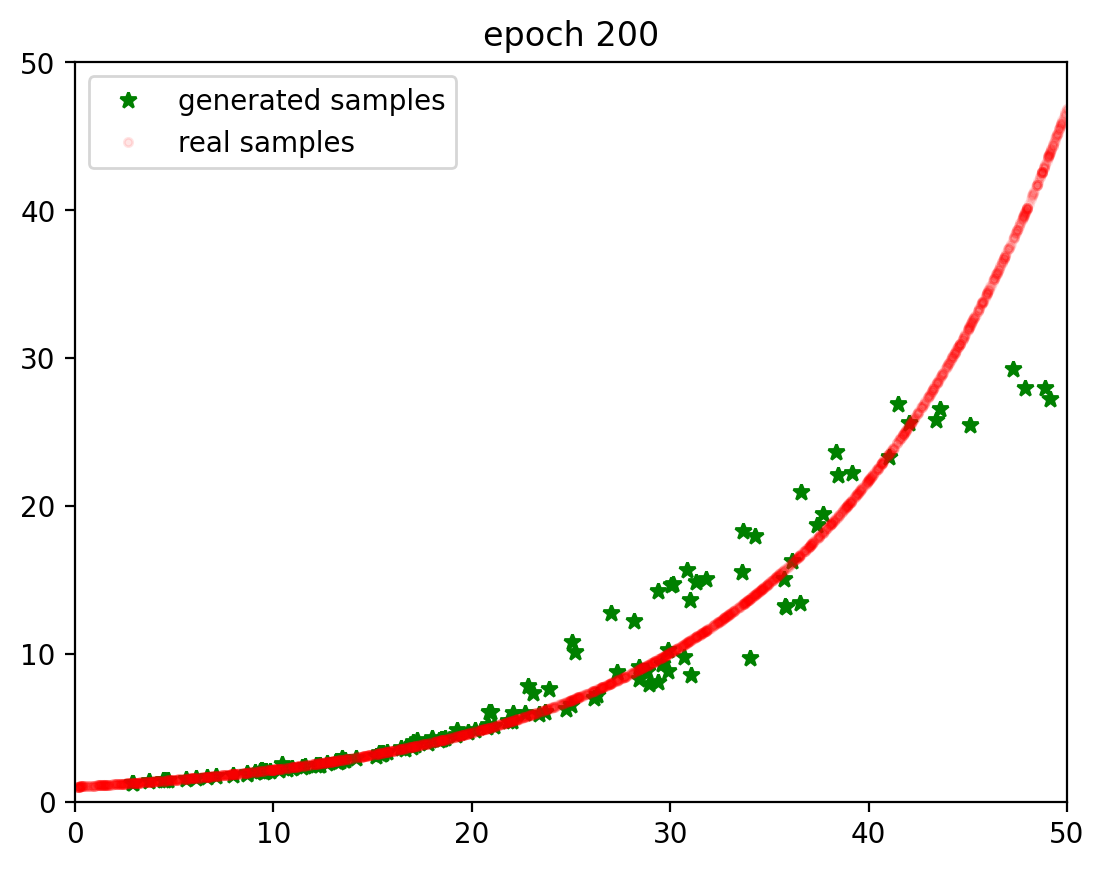

at epoch 224, G loss: 0.7593395868937175, D loss 1.4625528971354167


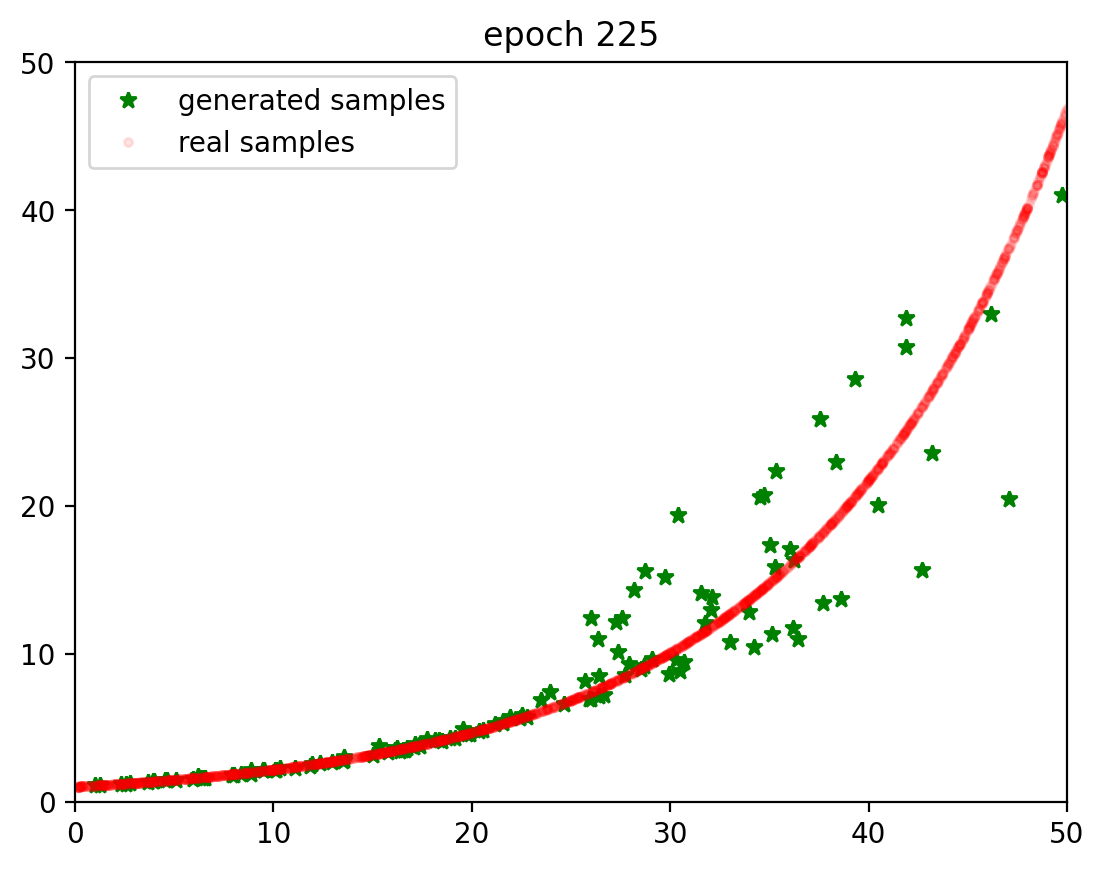

at epoch 249, G loss: 0.7588734944661458, D loss 1.4803604125976562


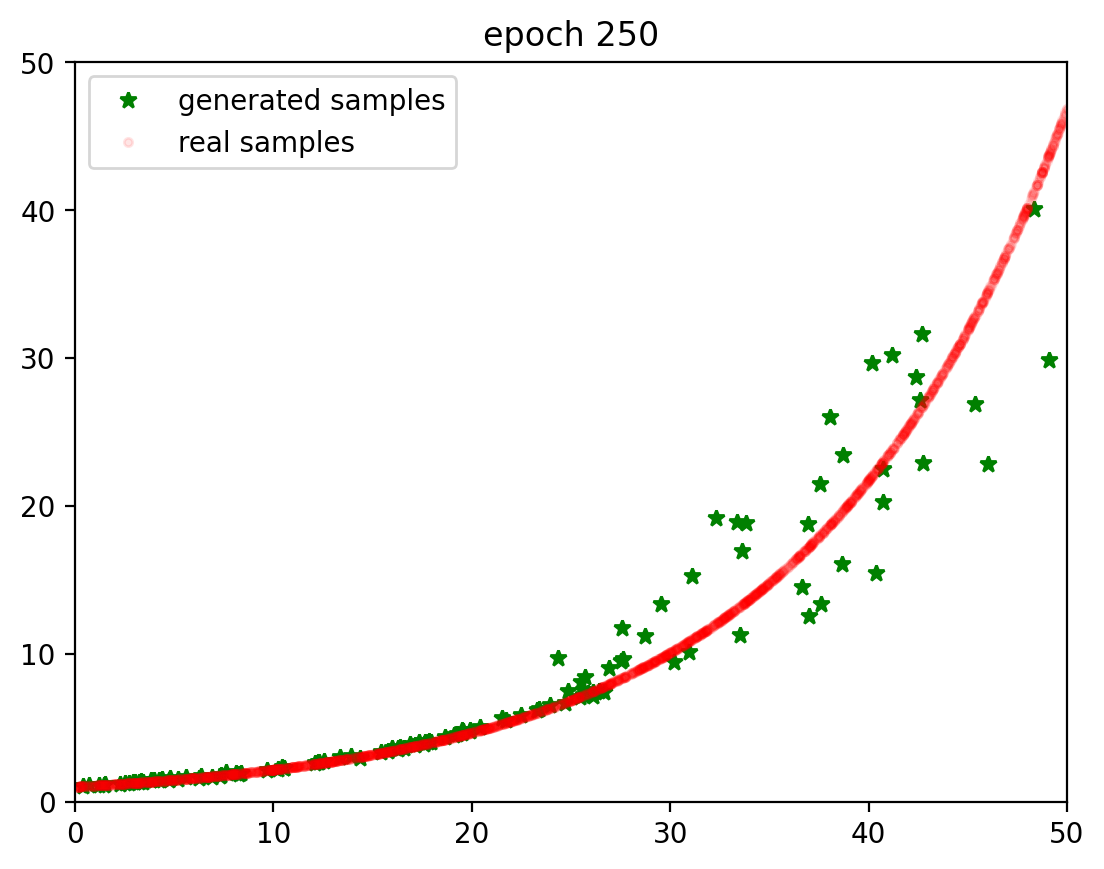

at epoch 274, G loss: 0.7620594660441081, D loss 1.4715187072753906


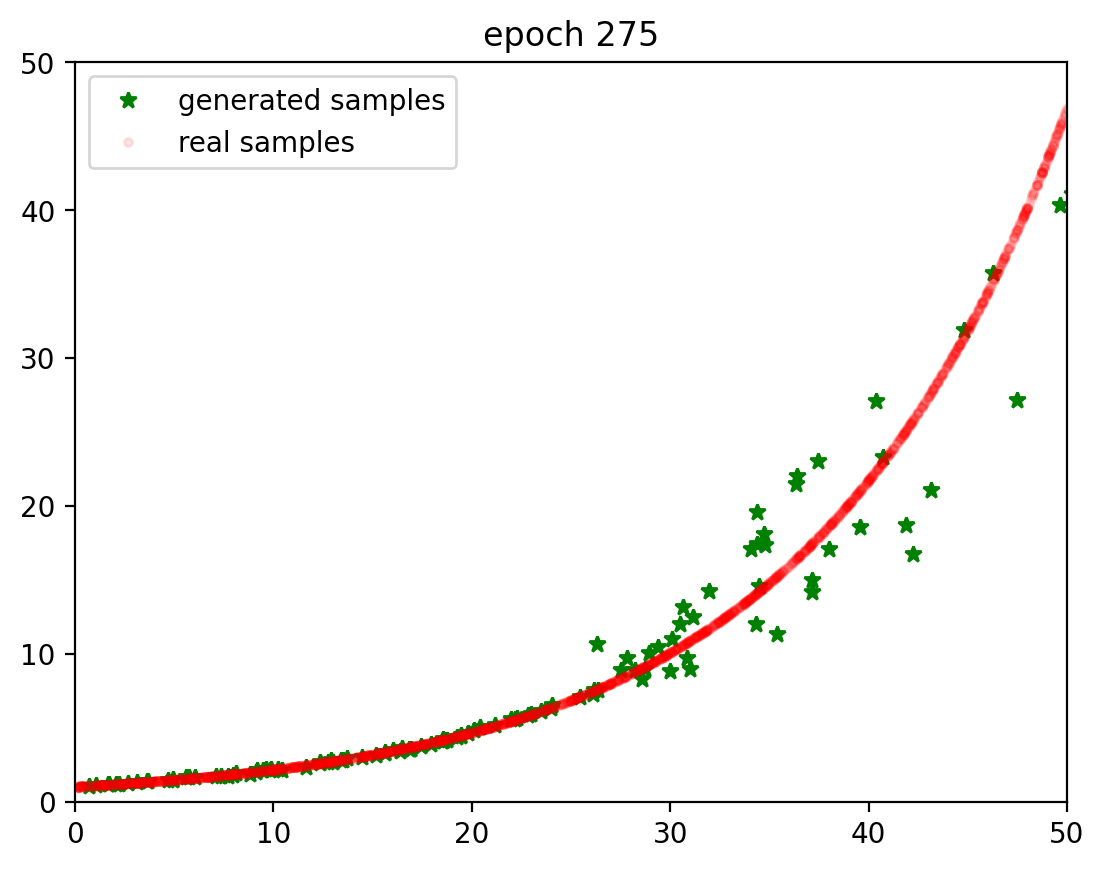

at epoch 299, G loss: 0.7598381042480469, D loss 1.4756303151448569


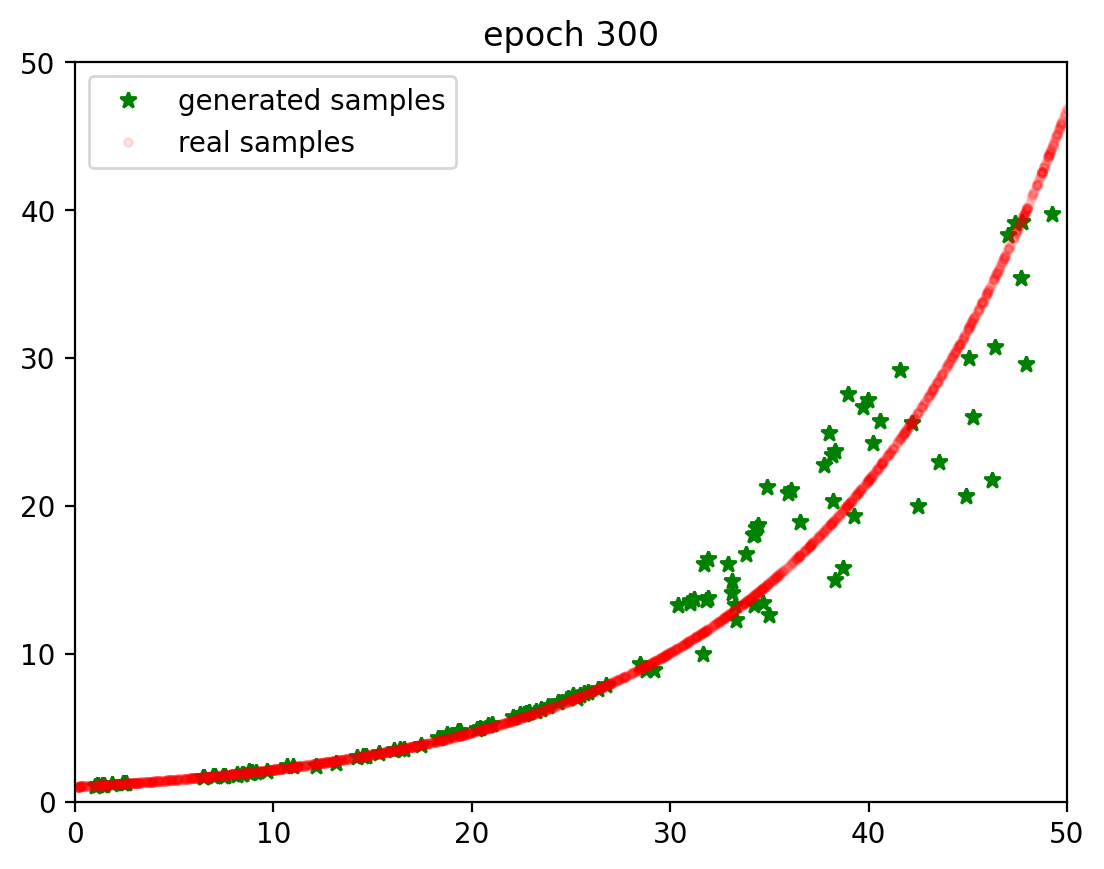

at epoch 324, G loss: 0.7550034840901693, D loss 1.4759179433186849


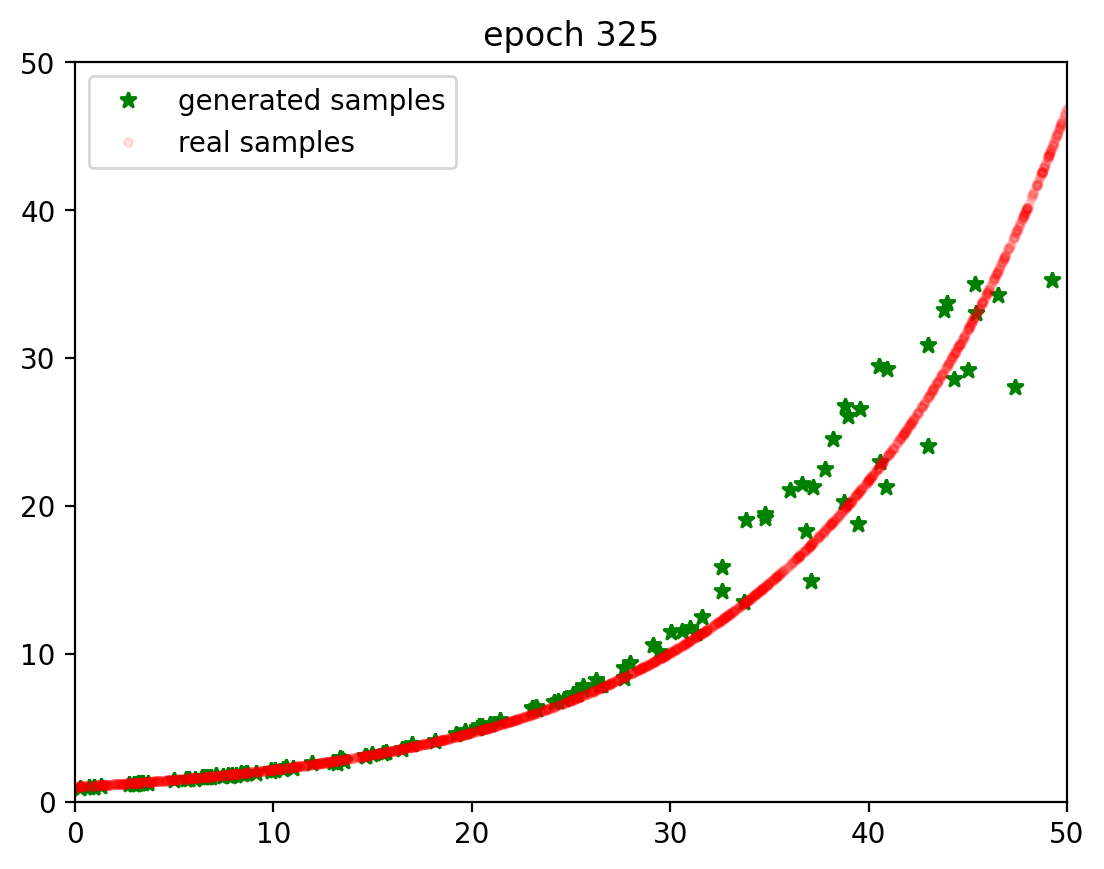

at epoch 349, G loss: 0.7482308069864909, D loss 1.476950709025065


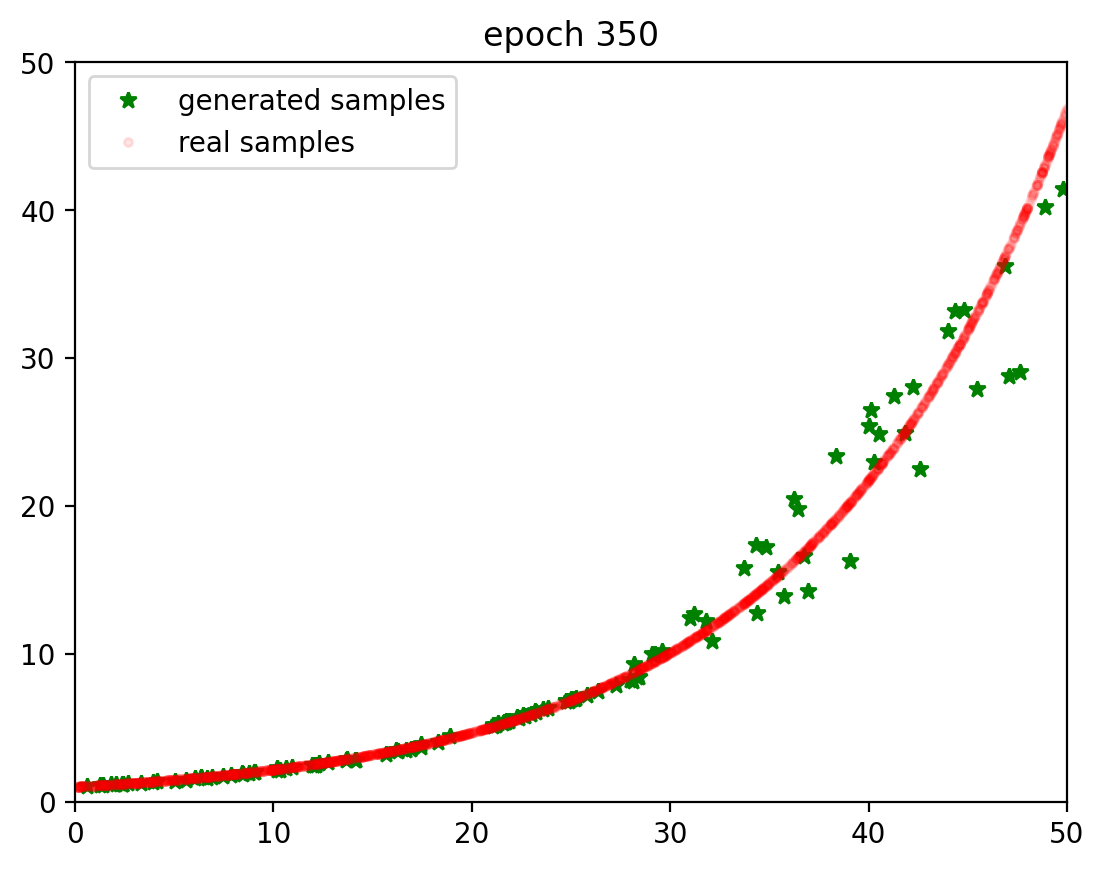

at epoch 374, G loss: 0.745364761352539, D loss 1.4749176025390625


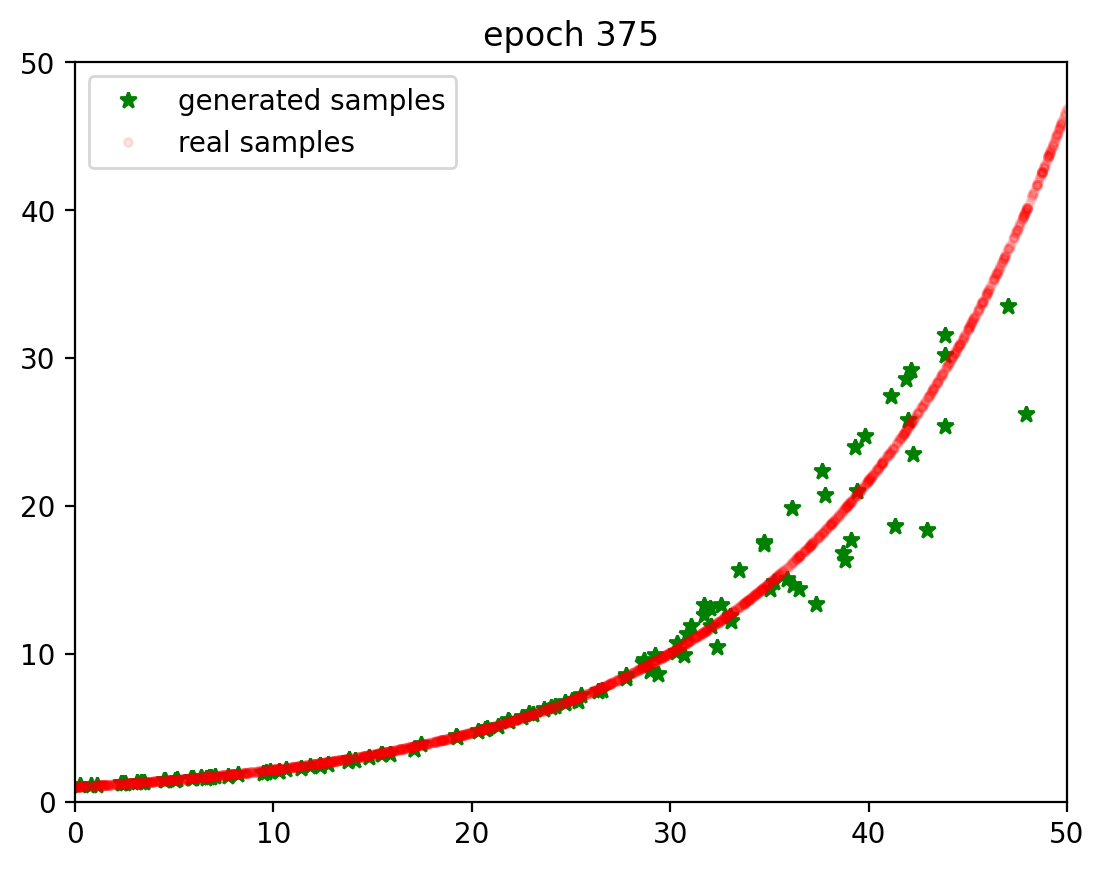

at epoch 399, G loss: 0.7486573537190755, D loss 1.477664311726888


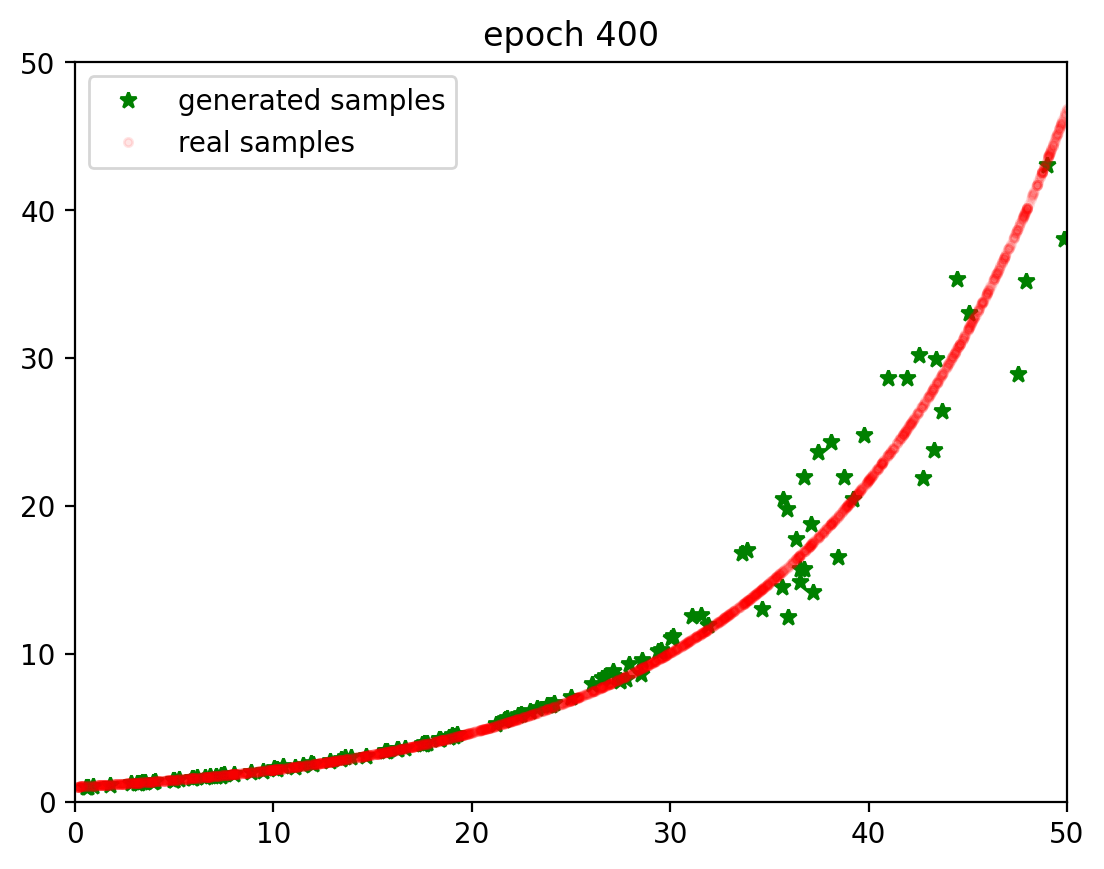

at epoch 424, G loss: 0.7495831807454427, D loss 1.474293009440104


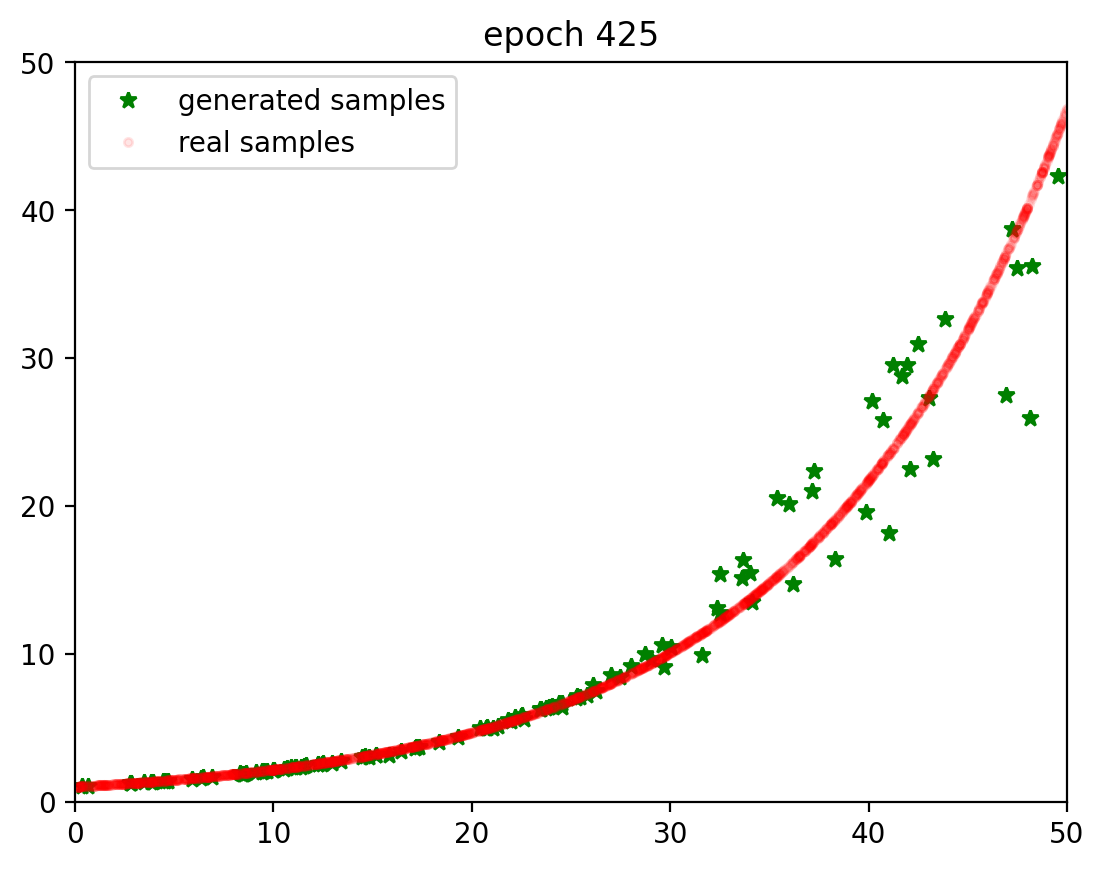

at epoch 449, G loss: 0.7518478393554687, D loss 1.477344004313151


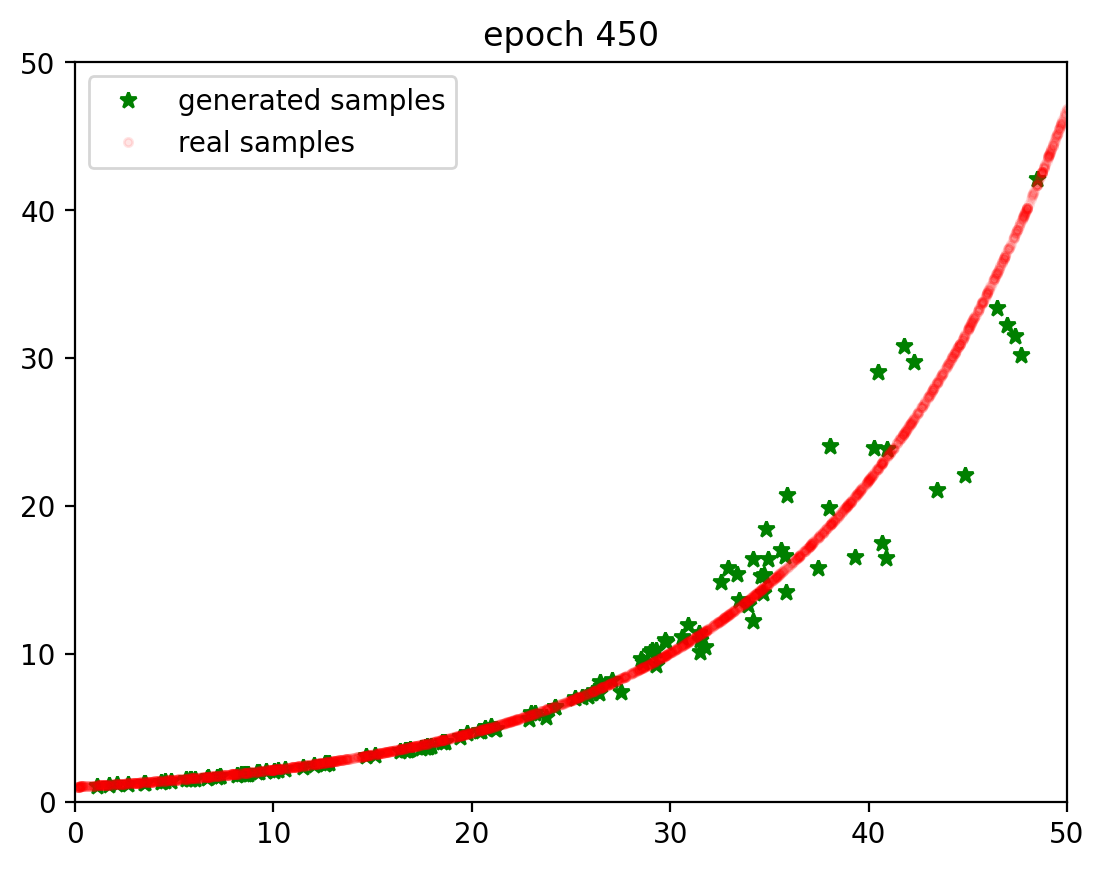

at epoch 474, G loss: 0.7497528711954753, D loss 1.47708371480306


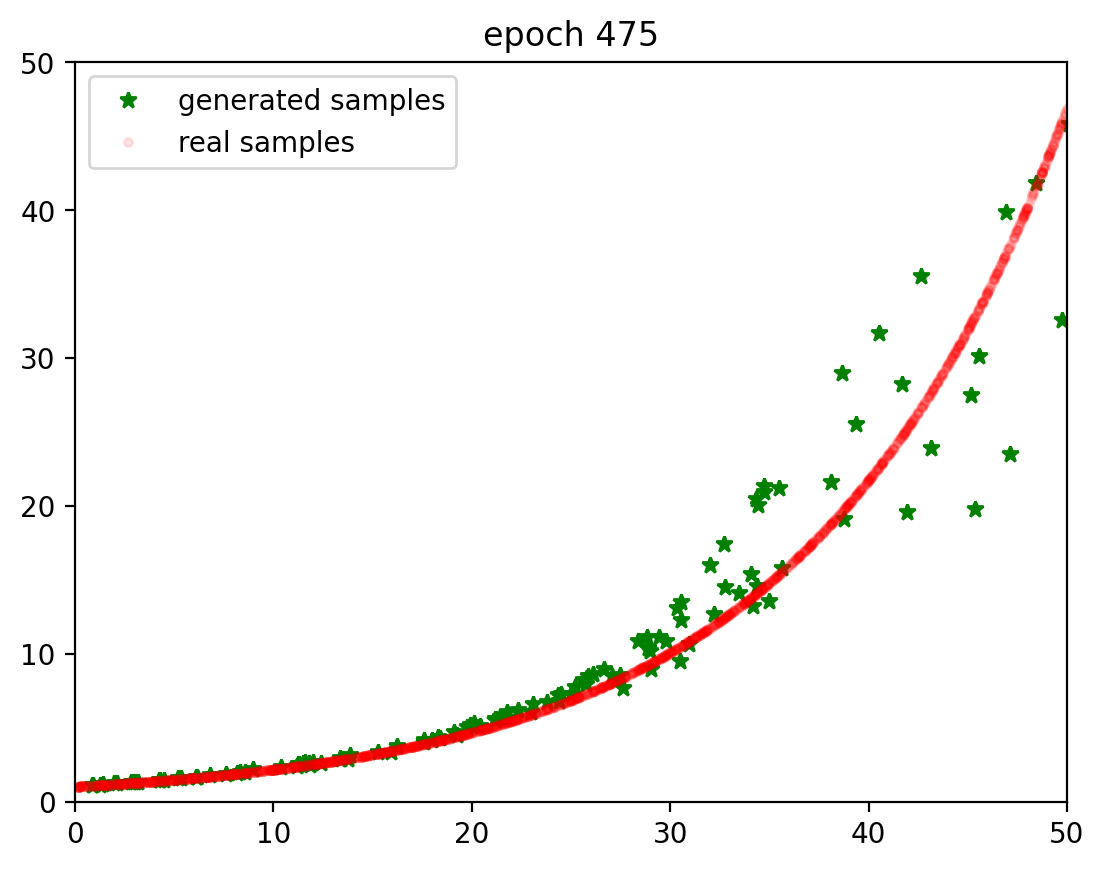

at epoch 499, G loss: 0.7431479771931966, D loss 1.472811508178711


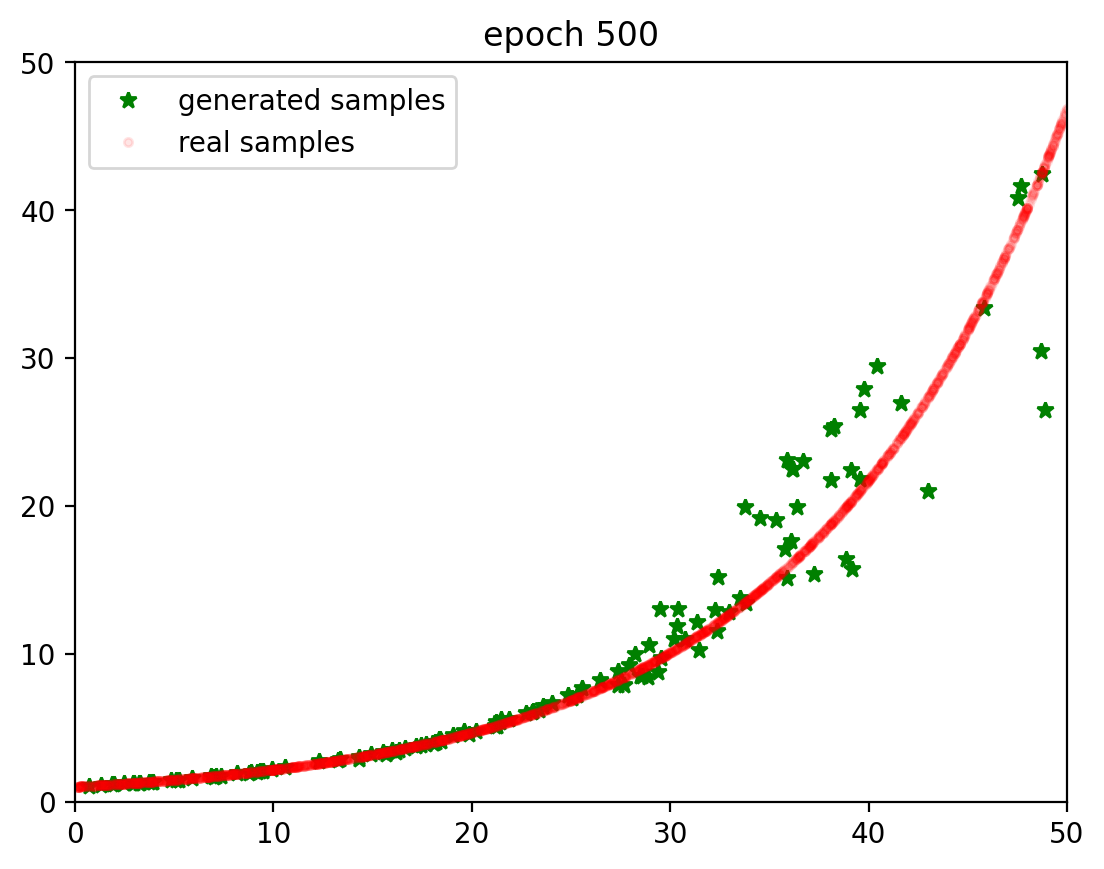

at epoch 524, G loss: 0.7444816589355469, D loss 1.4715784708658854


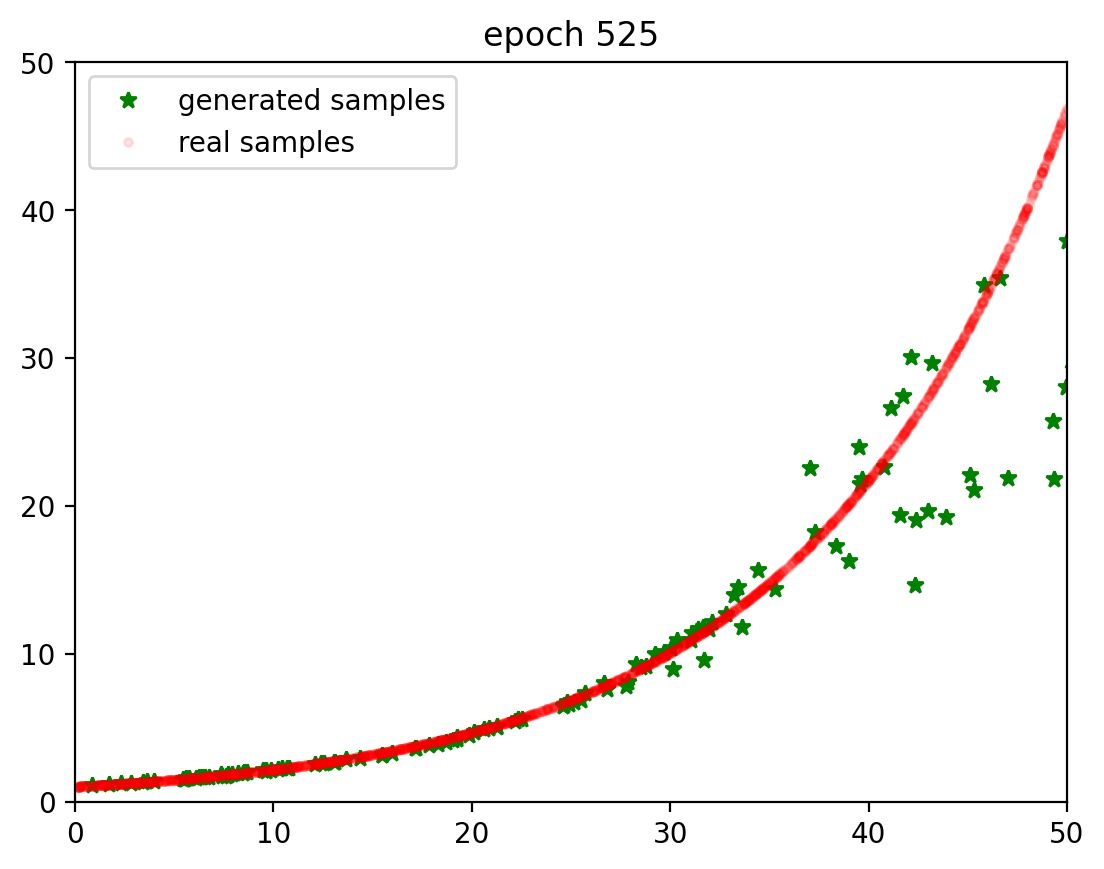

at epoch 549, G loss: 0.7437498092651367, D loss 1.4733812967936197


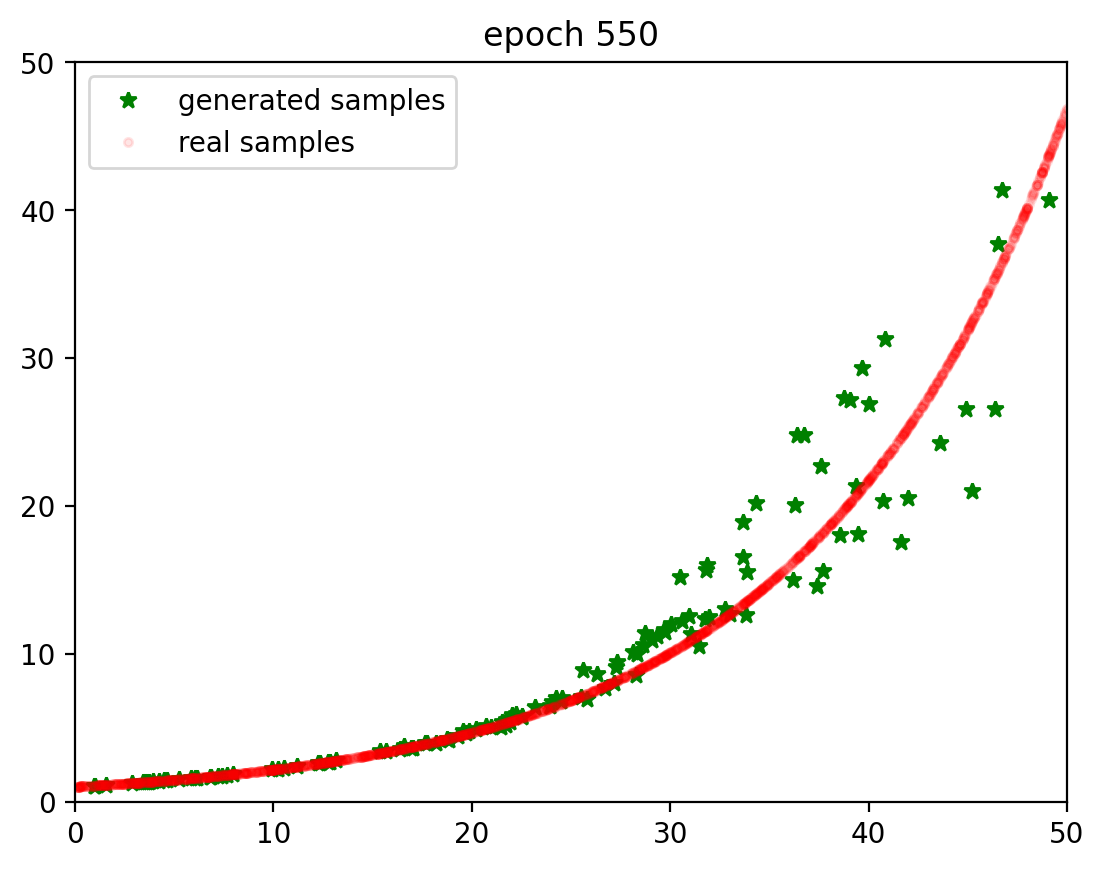

at epoch 574, G loss: 0.7394700368245443, D loss 1.4744940439860026


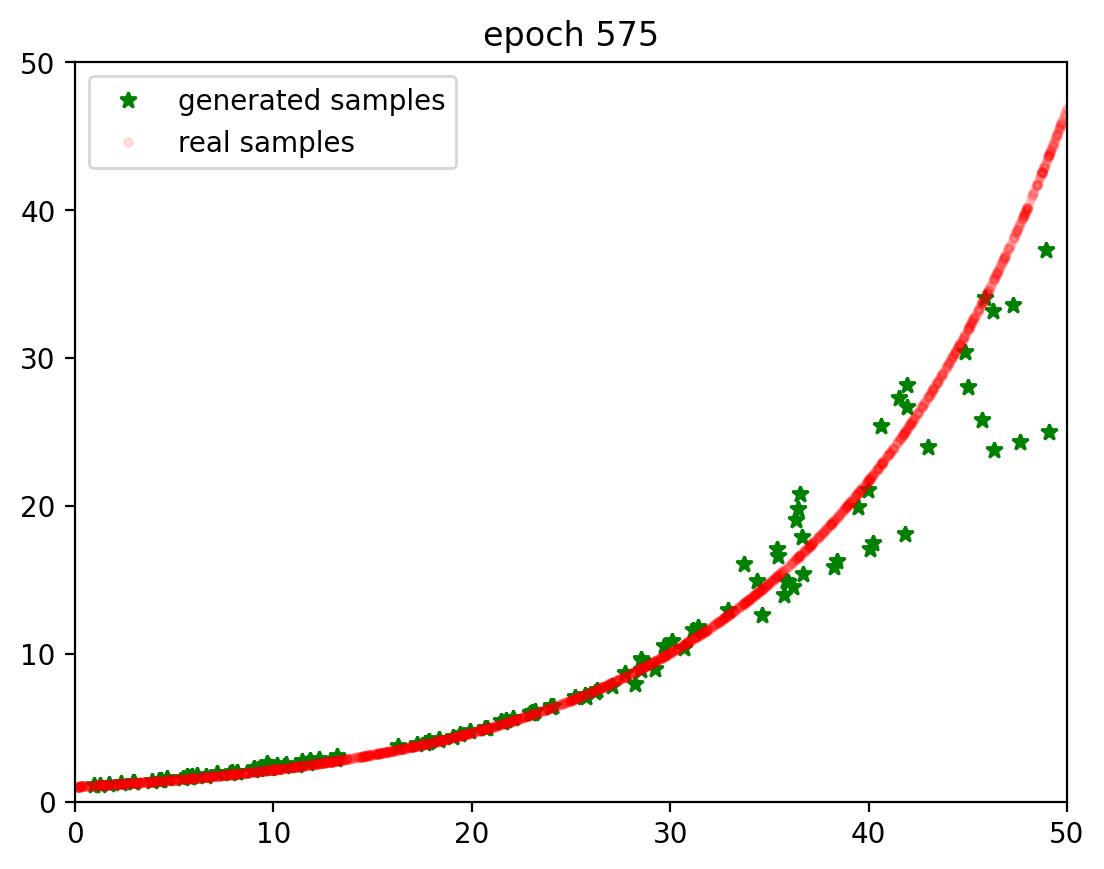

at epoch 599, G loss: 0.7420352300008138, D loss 1.4666067759195964


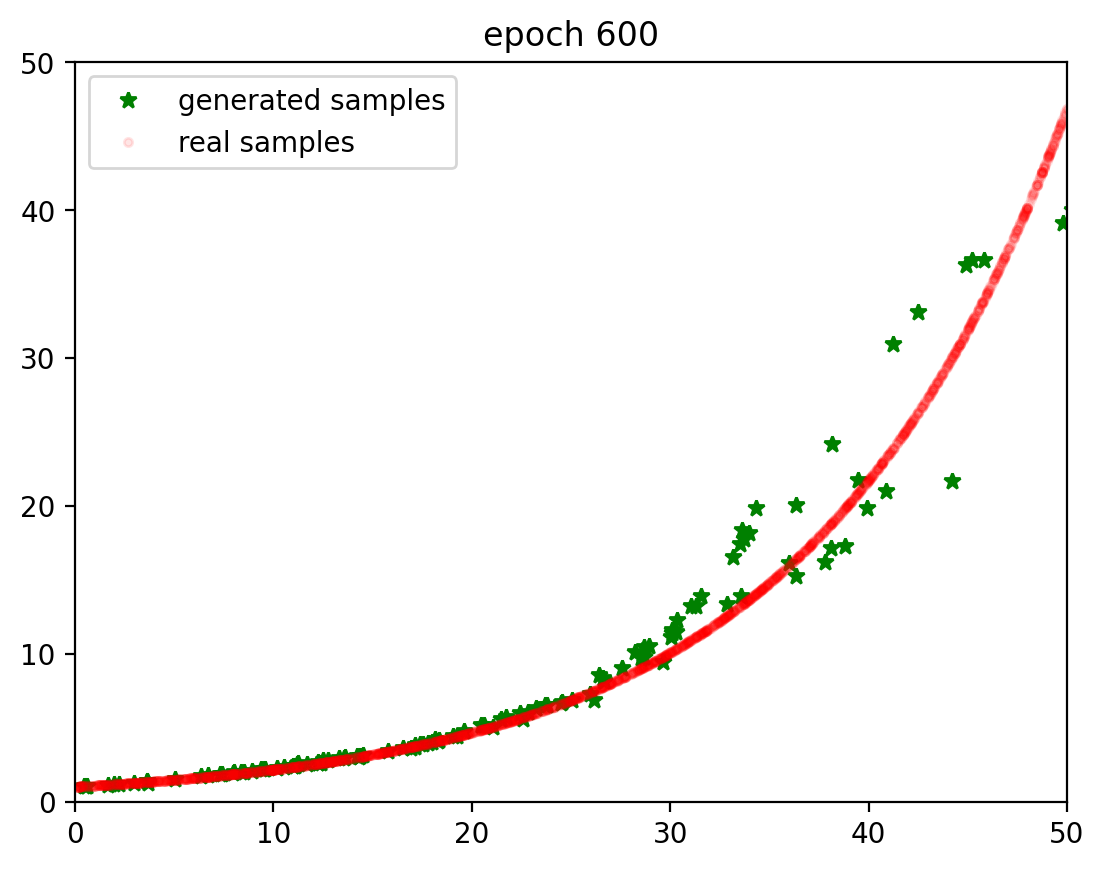

at epoch 624, G loss: 0.7441598256429036, D loss 1.4755989074707032


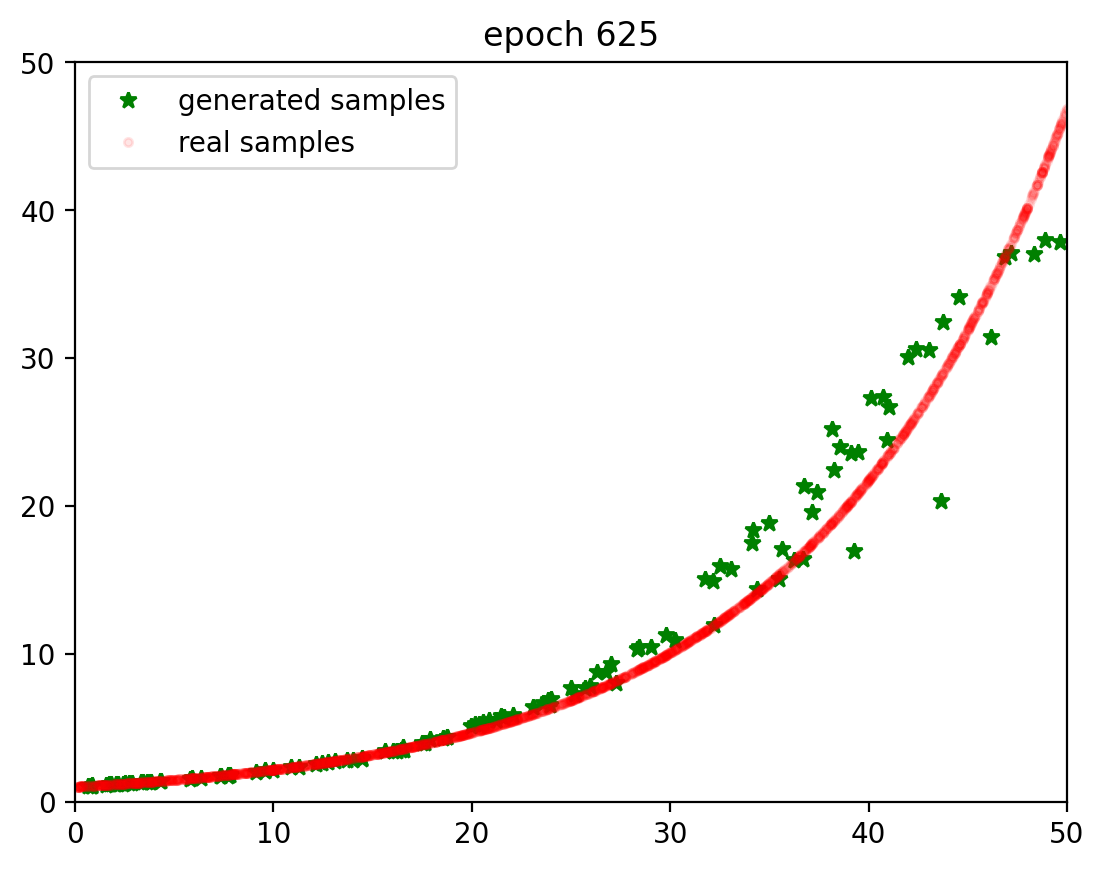

at epoch 649, G loss: 0.7484678904215495, D loss 1.469680913289388


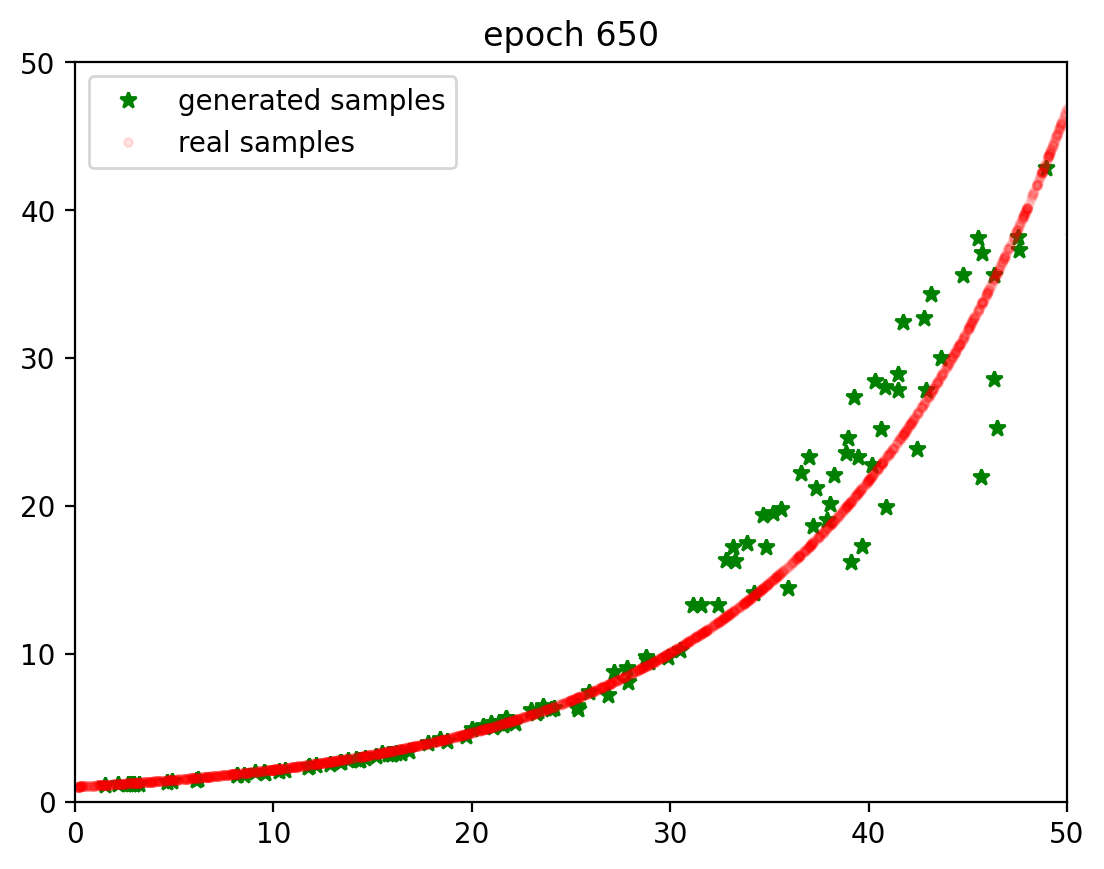

at epoch 674, G loss: 0.7463445663452148, D loss 1.4772432963053386


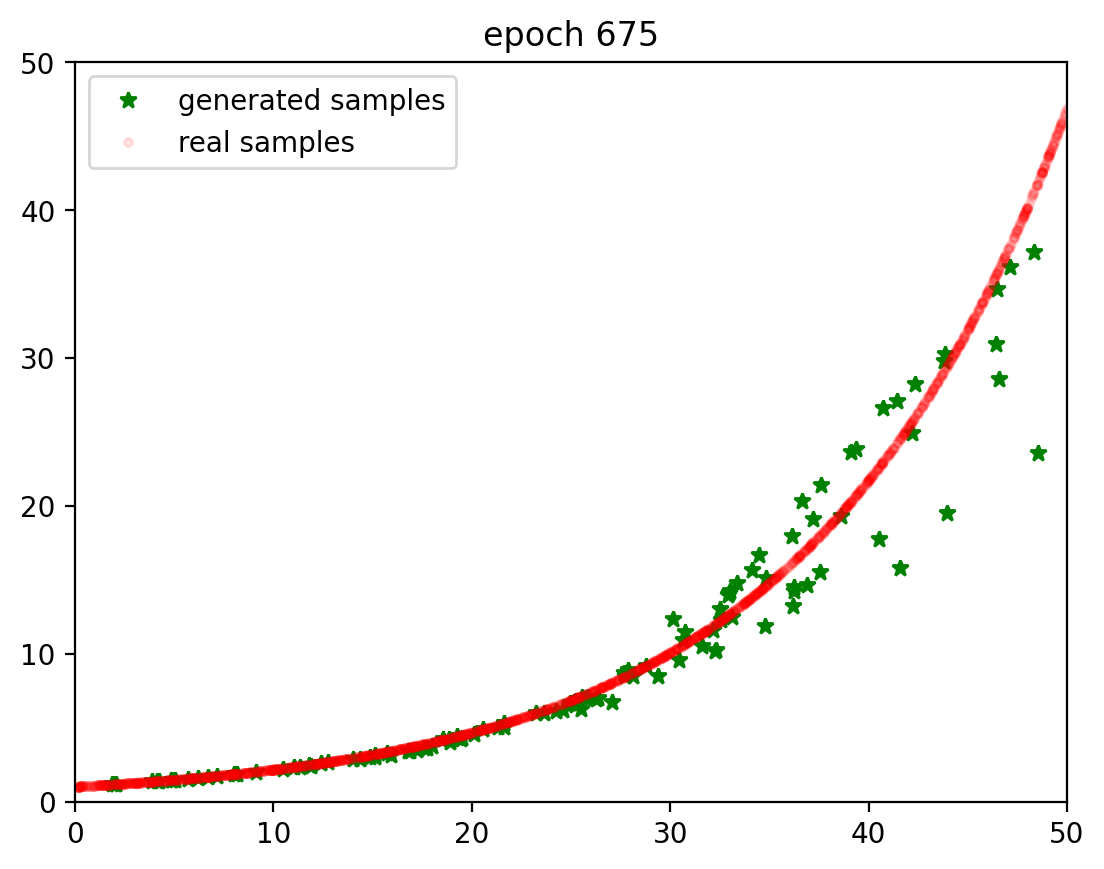

at epoch 699, G loss: 0.7479325612386067, D loss 1.4754128774007162


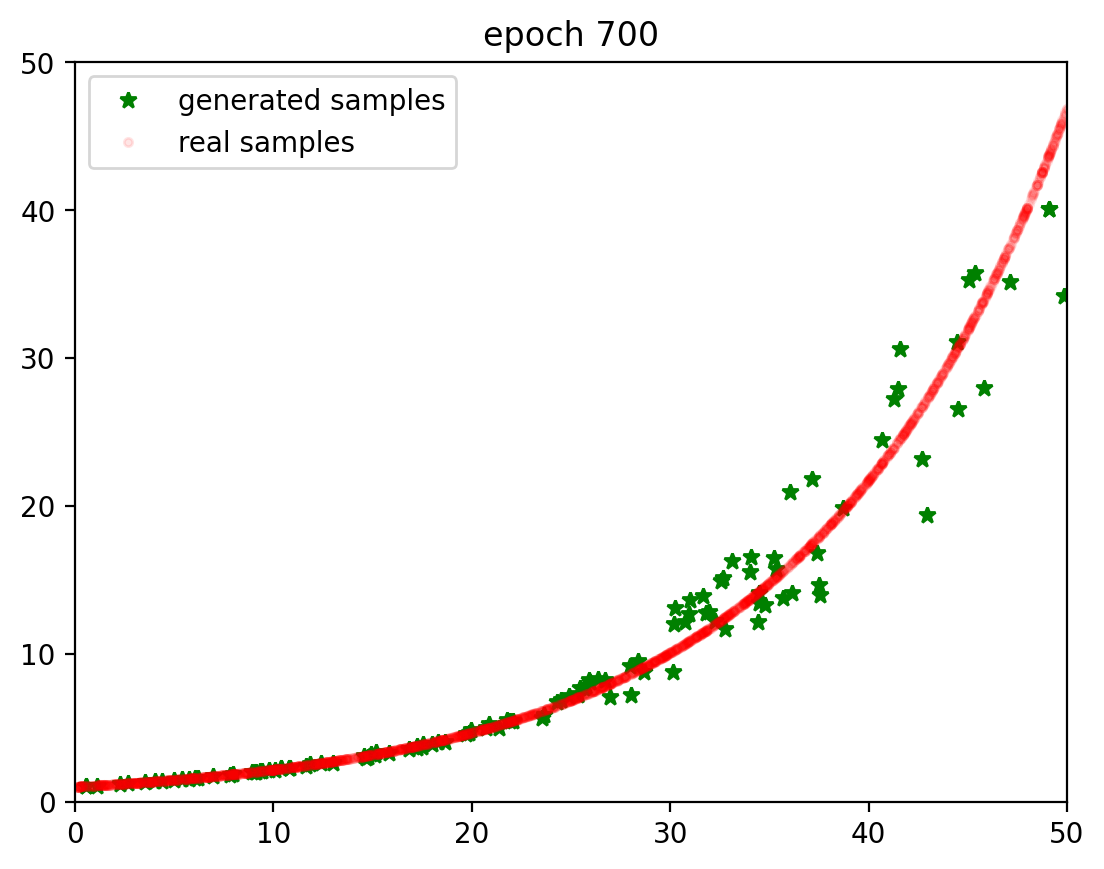

at epoch 724, G loss: 0.7437838872273763, D loss 1.4712337493896483


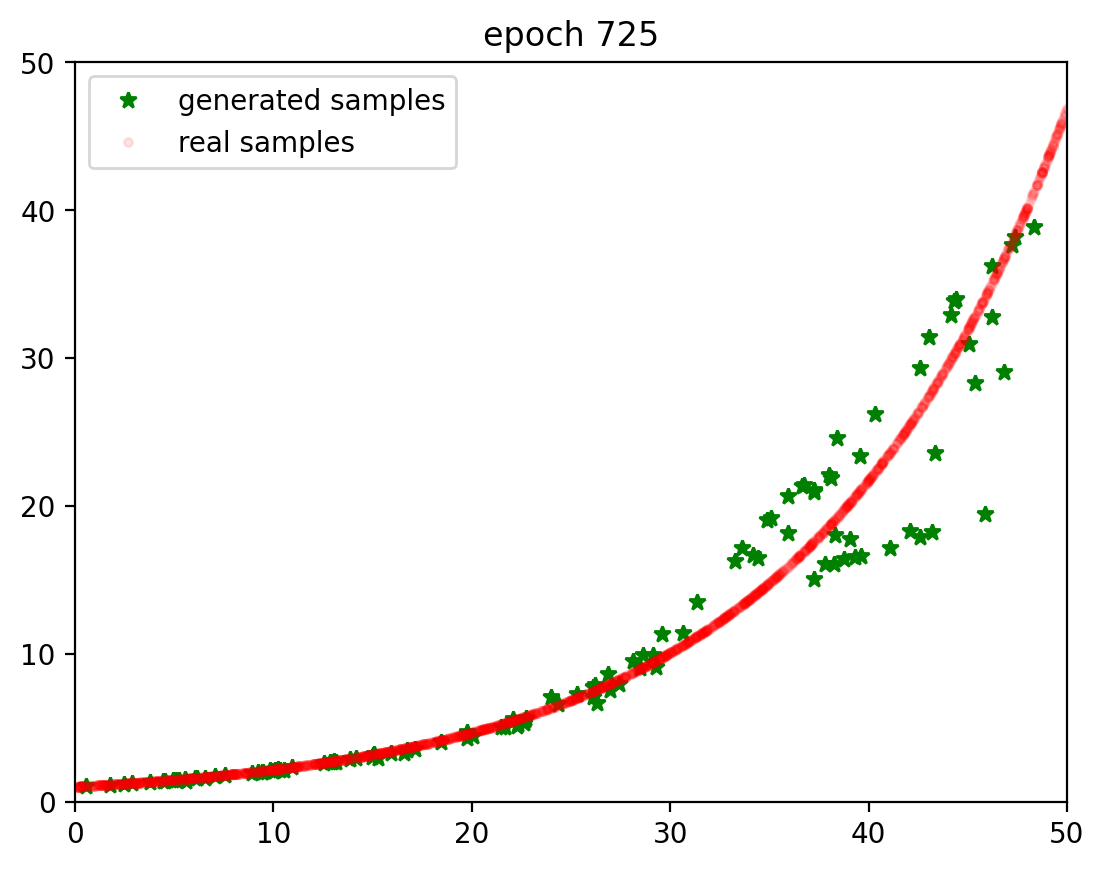

at epoch 749, G loss: 0.7453837712605794, D loss 1.4764329274495442


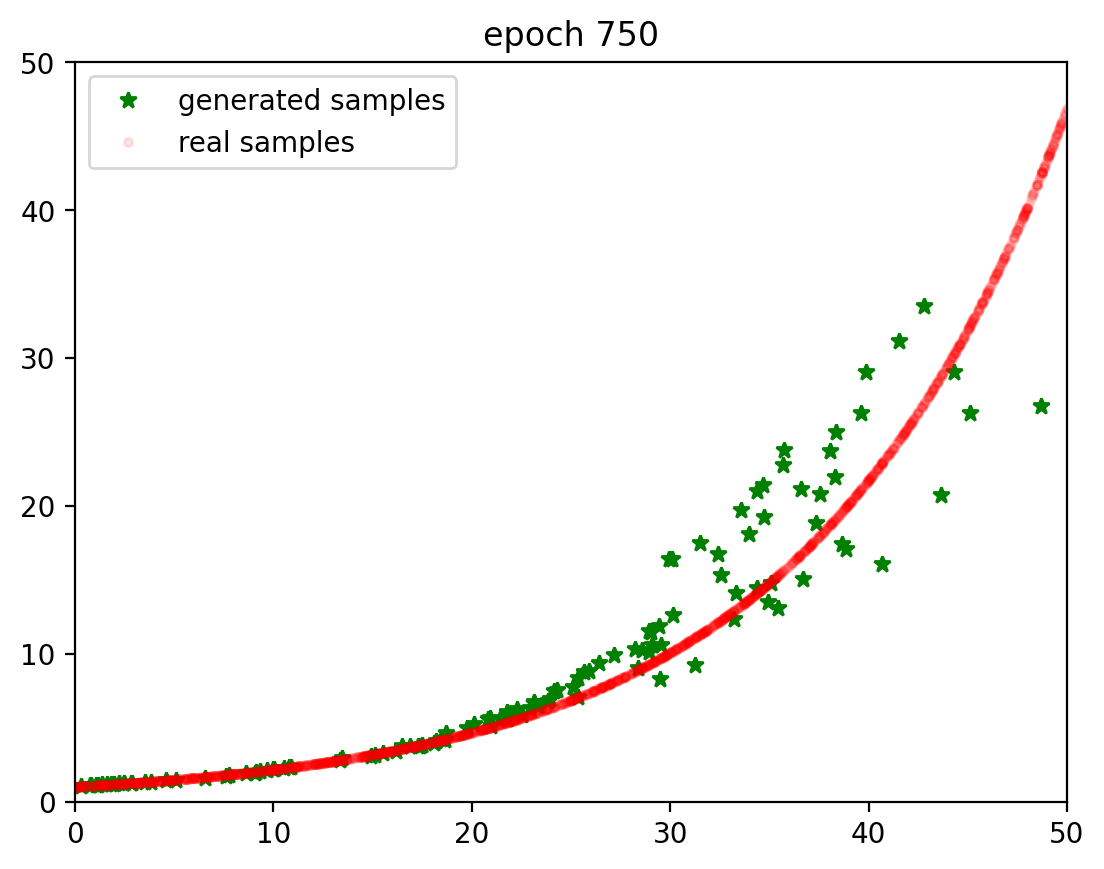

at epoch 774, G loss: 0.7415573755900066, D loss 1.4797383626302083


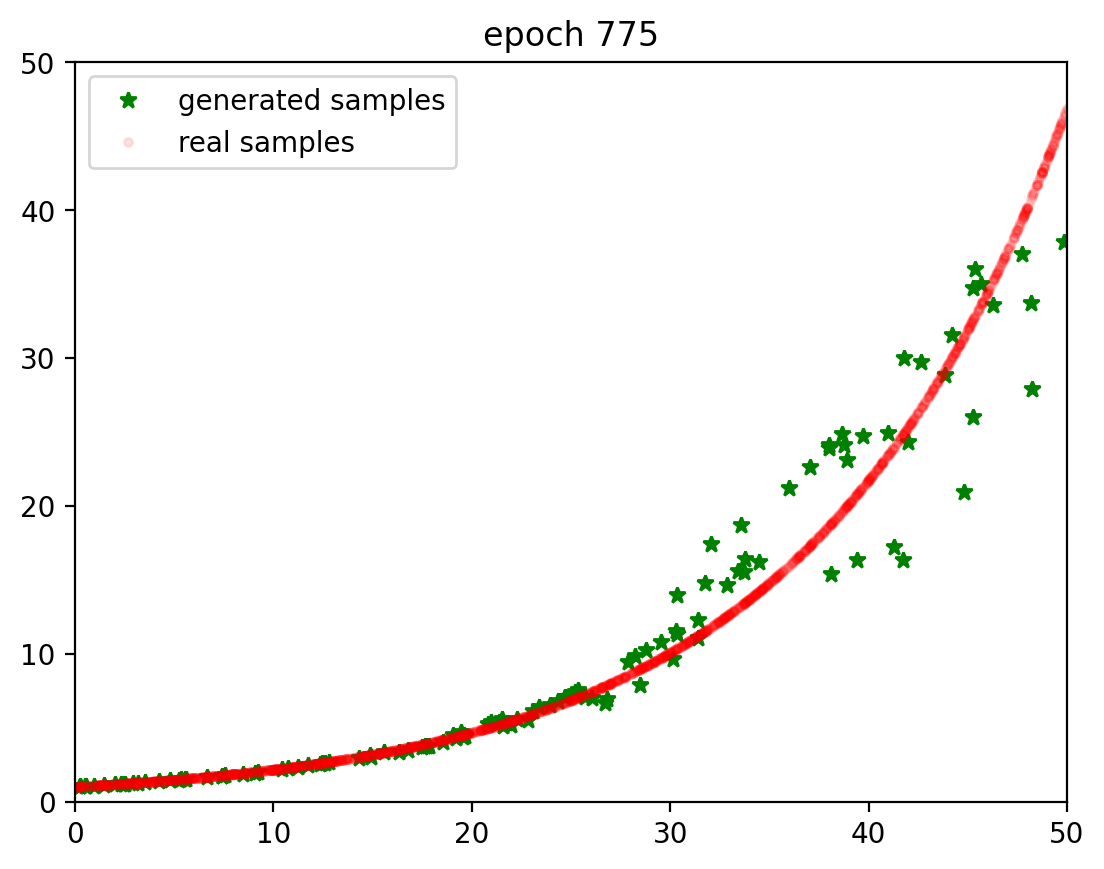

at epoch 799, G loss: 0.7477111180623373, D loss 1.4818603515625


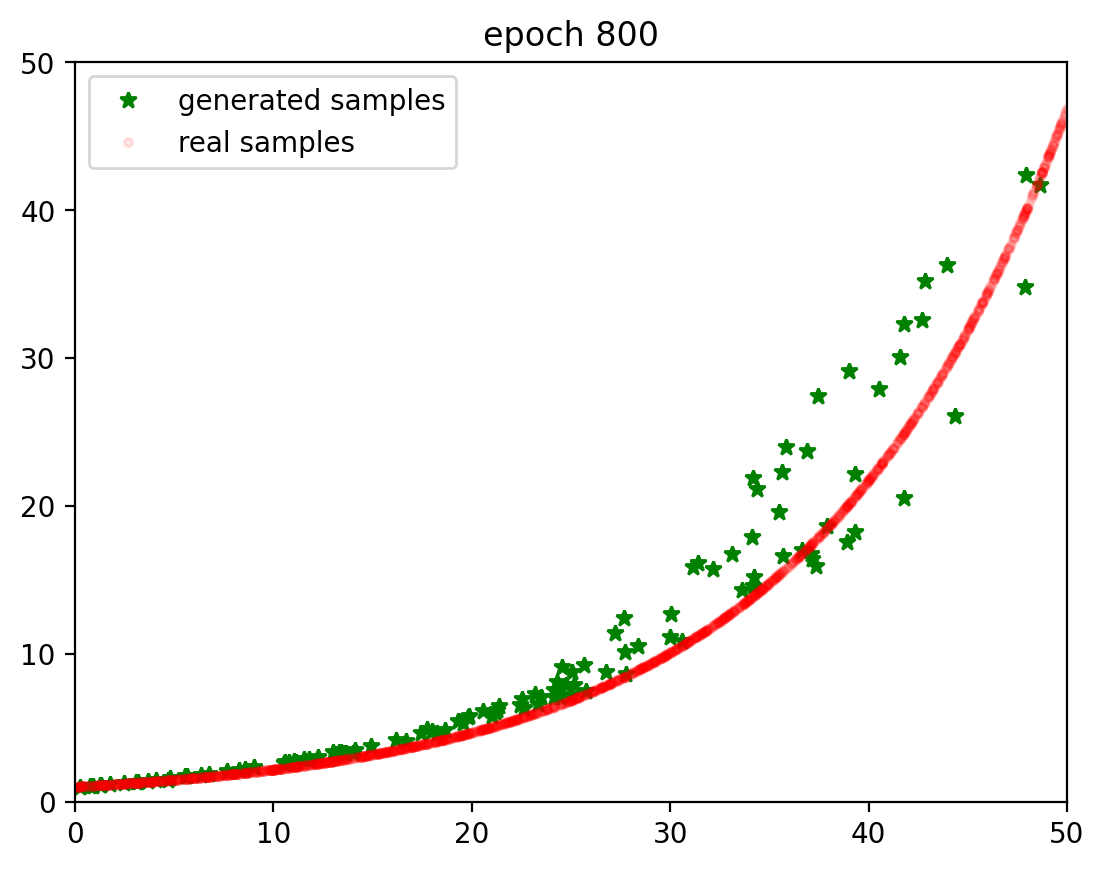

at epoch 824, G loss: 0.7408990224202474, D loss 1.4774940490722657


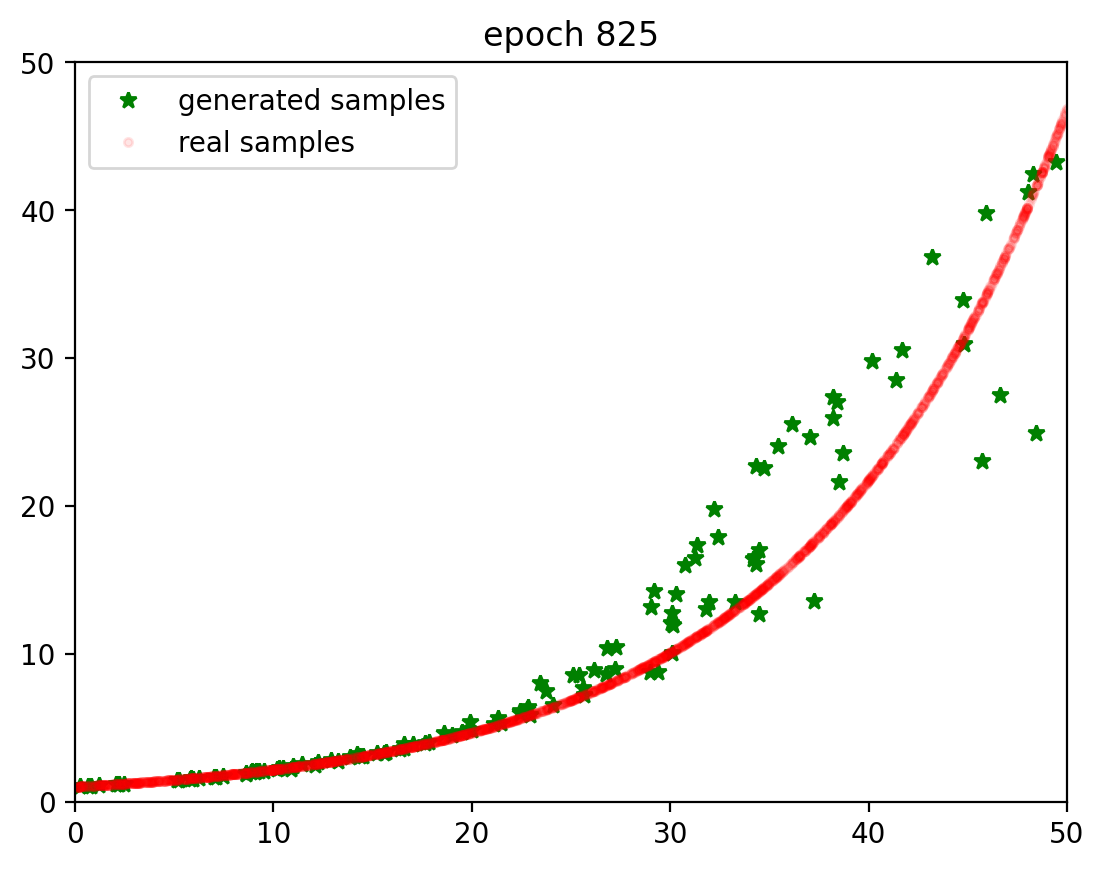

at epoch 849, G loss: 0.7426277160644531, D loss 1.4789695739746094


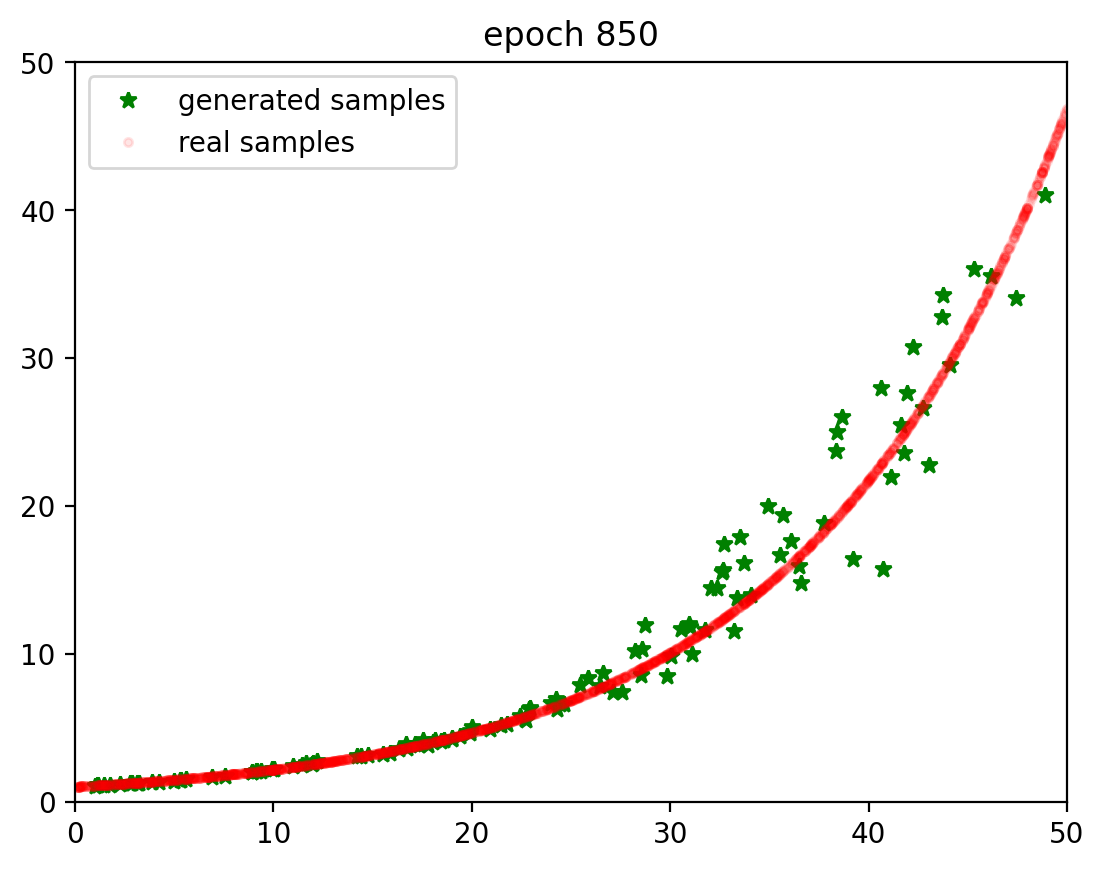

at epoch 874, G loss: 0.7427391688028971, D loss 1.4787298838297527


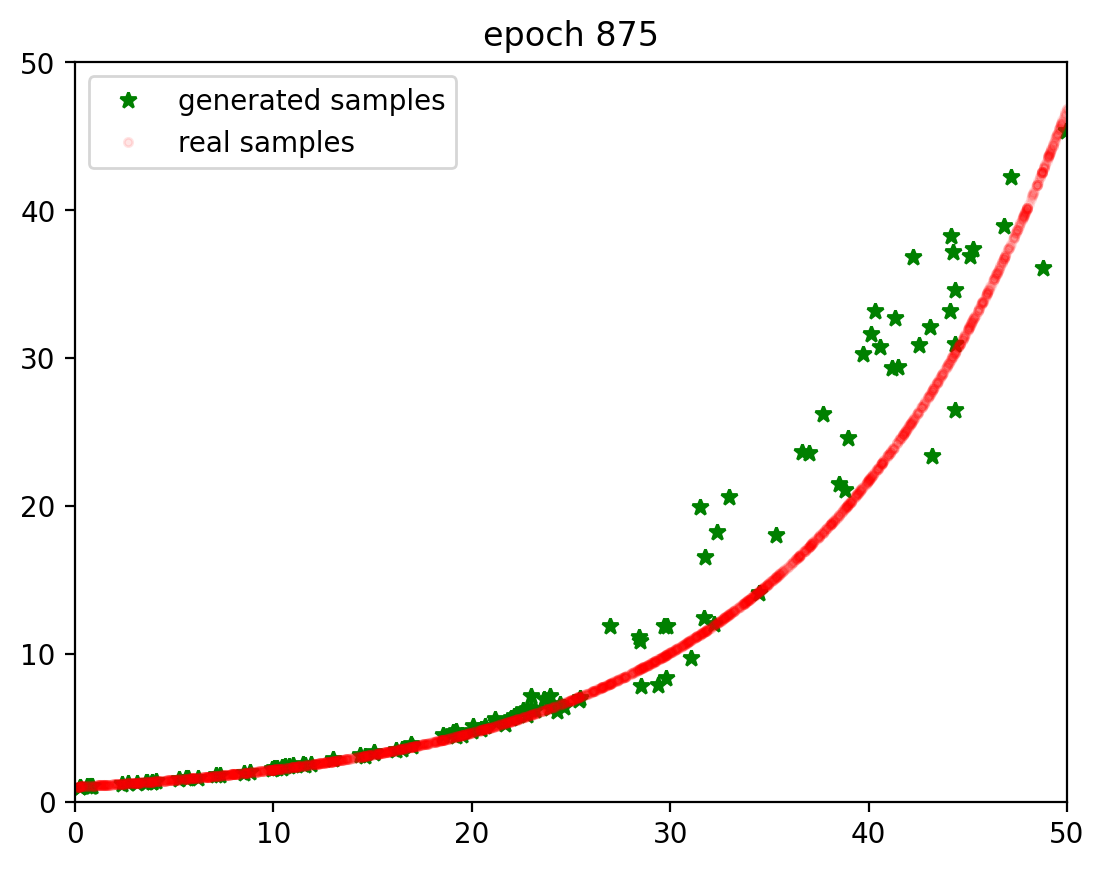

at epoch 899, G loss: 0.740141487121582, D loss 1.4778834025065104


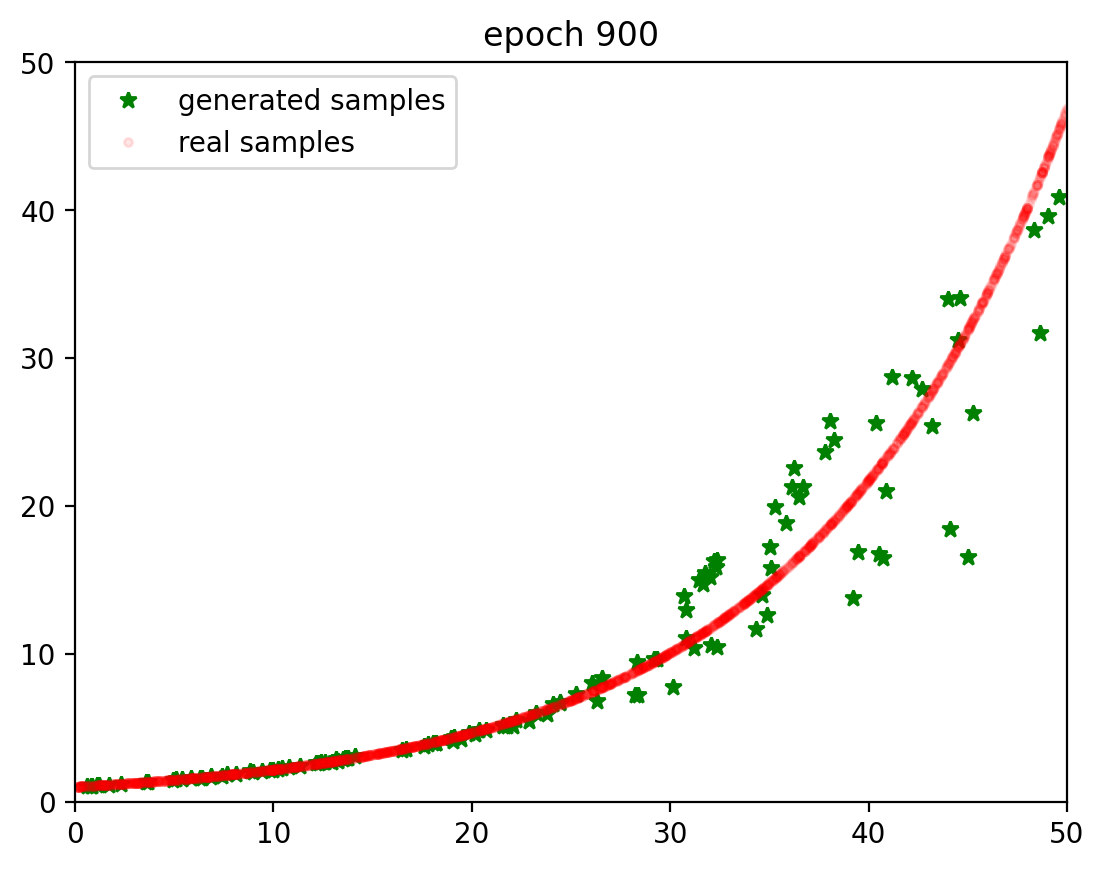

at epoch 924, G loss: 0.7435478846232096, D loss 1.4793145497639975


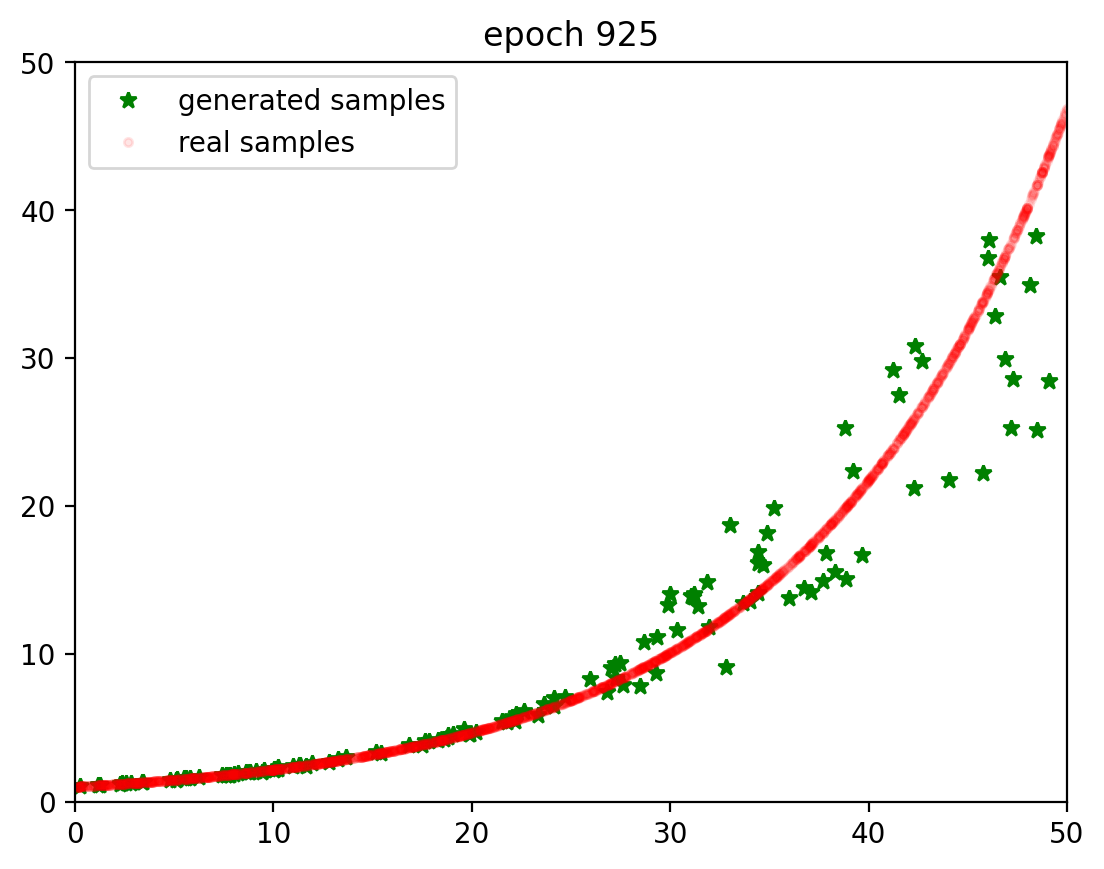

at epoch 949, G loss: 0.749011739095052, D loss 1.4791464487711588


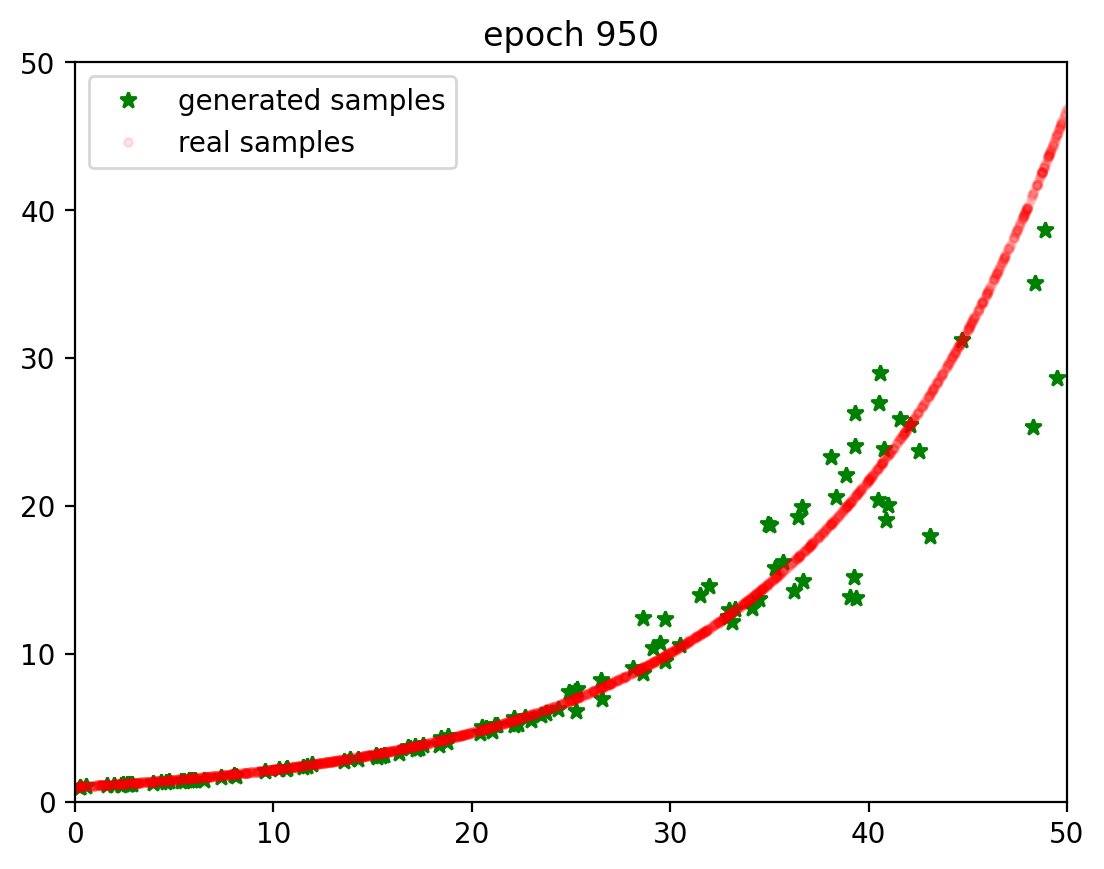

at epoch 974, G loss: 0.741057014465332, D loss 1.4788211822509765


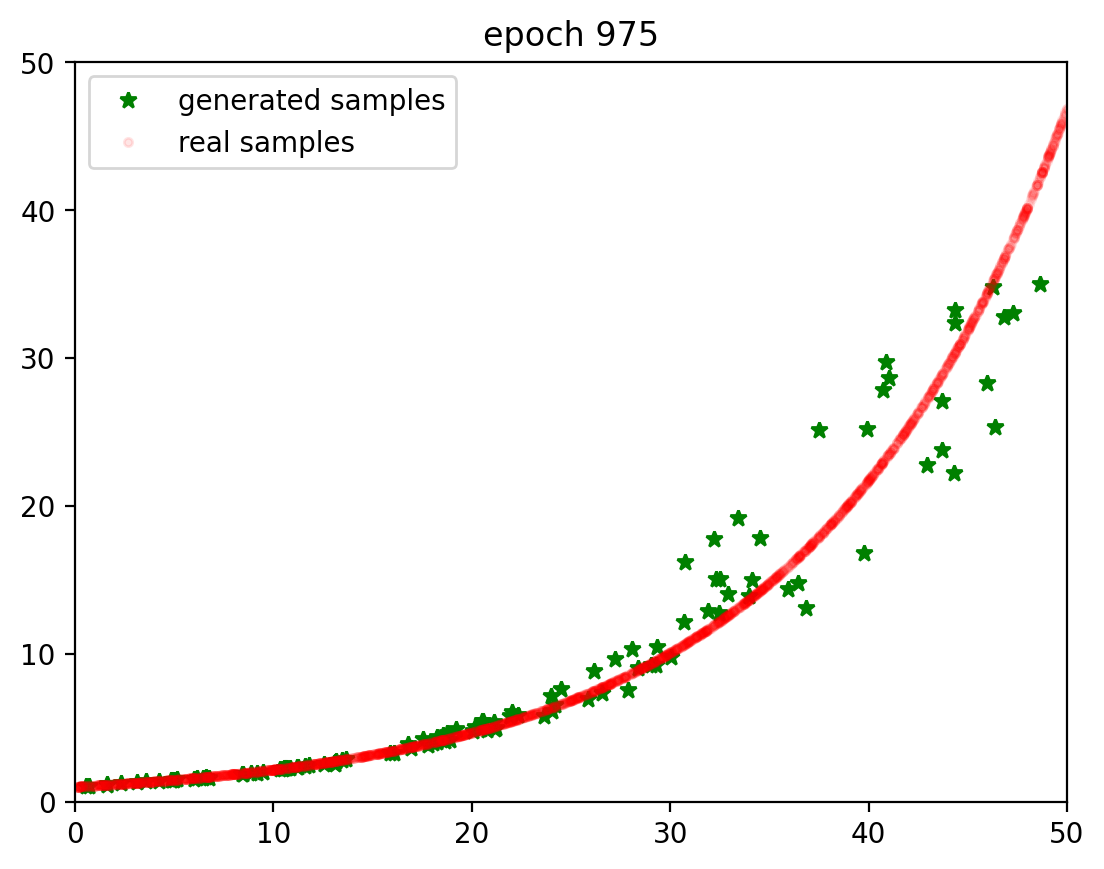

at epoch 999, G loss: 0.7403578440348307, D loss 1.480492401123047


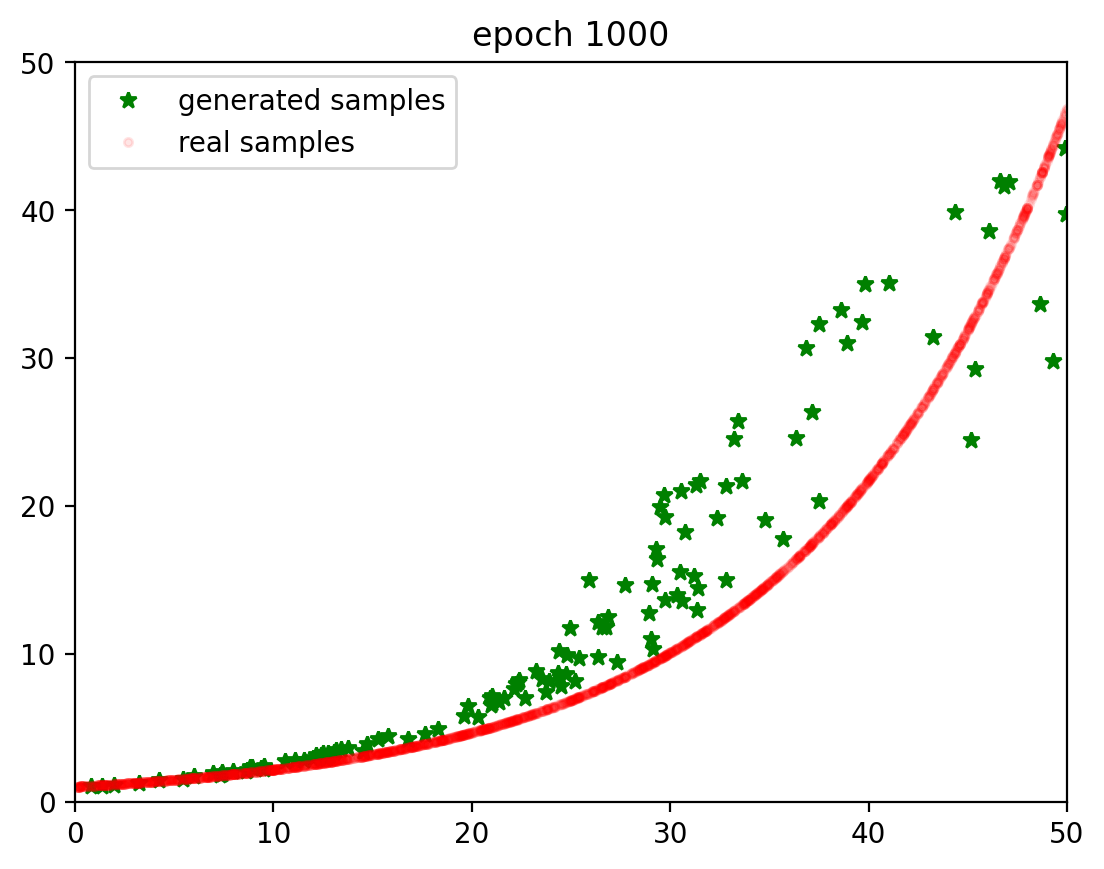

at epoch 1024, G loss: 0.7408397674560547, D loss 1.477859624226888


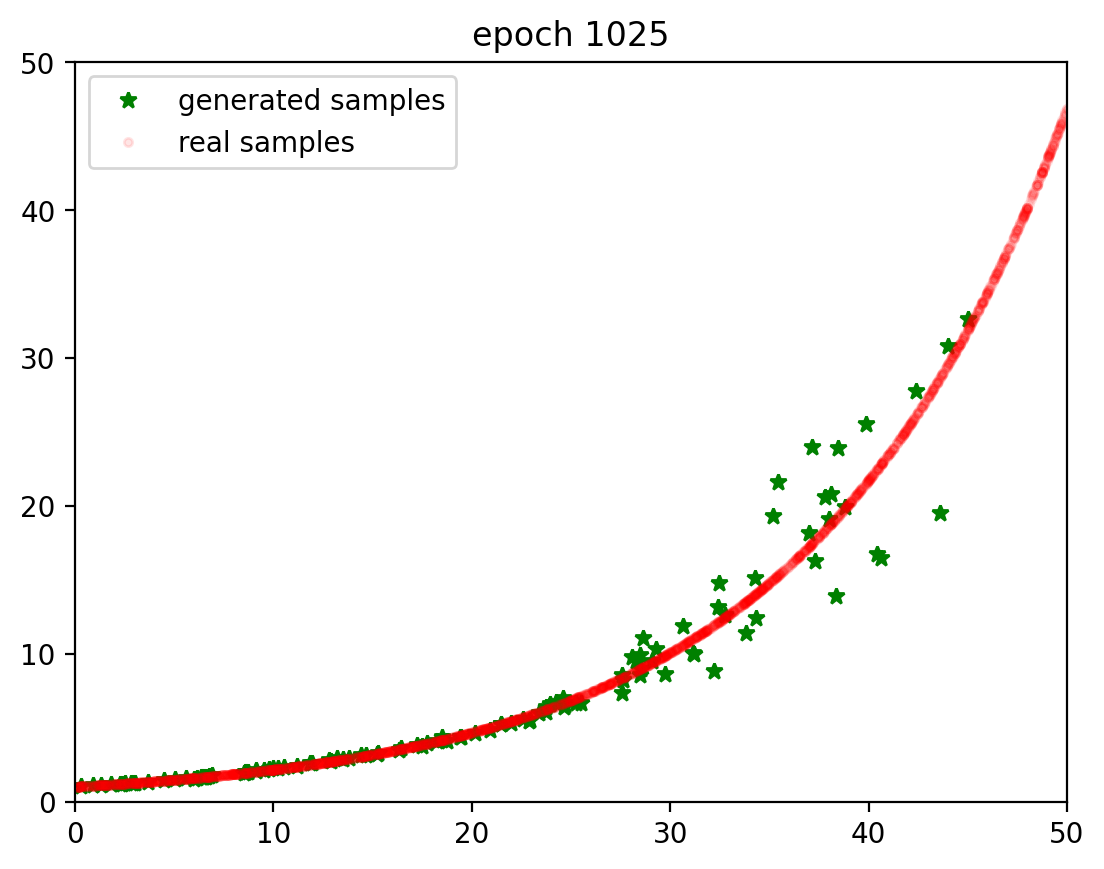

In [15]:
for epoch in range(10000):    #A
    gloss=0
    dloss=0
    for n, real_samples in enumerate(train_loader):    #B
        loss_D=train_D_on_real(real_samples)
        dloss+=loss_D
        loss_D=train_D_on_fake()
        dloss+=loss_D
        loss_G,fake_samples=train_G()
        gloss+=loss_G
    test_epoch(epoch,gloss,dloss,n)    #C
    gdif=performance(fake_samples).item()
    if stopper.stop(gdif)==True:    #D
        break

## 3.2. Save and Use the Trained Model

In [16]:
scripted = torch.jit.script(G) 
scripted.save('files/exponential.pt') 

In [17]:
new_G=torch.jit.load('files/exponential.pt',
                     map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=Linear)
)

In [18]:
noise=torch.randn((batch_size,2)).to(device)
new_data=new_G(noise) 

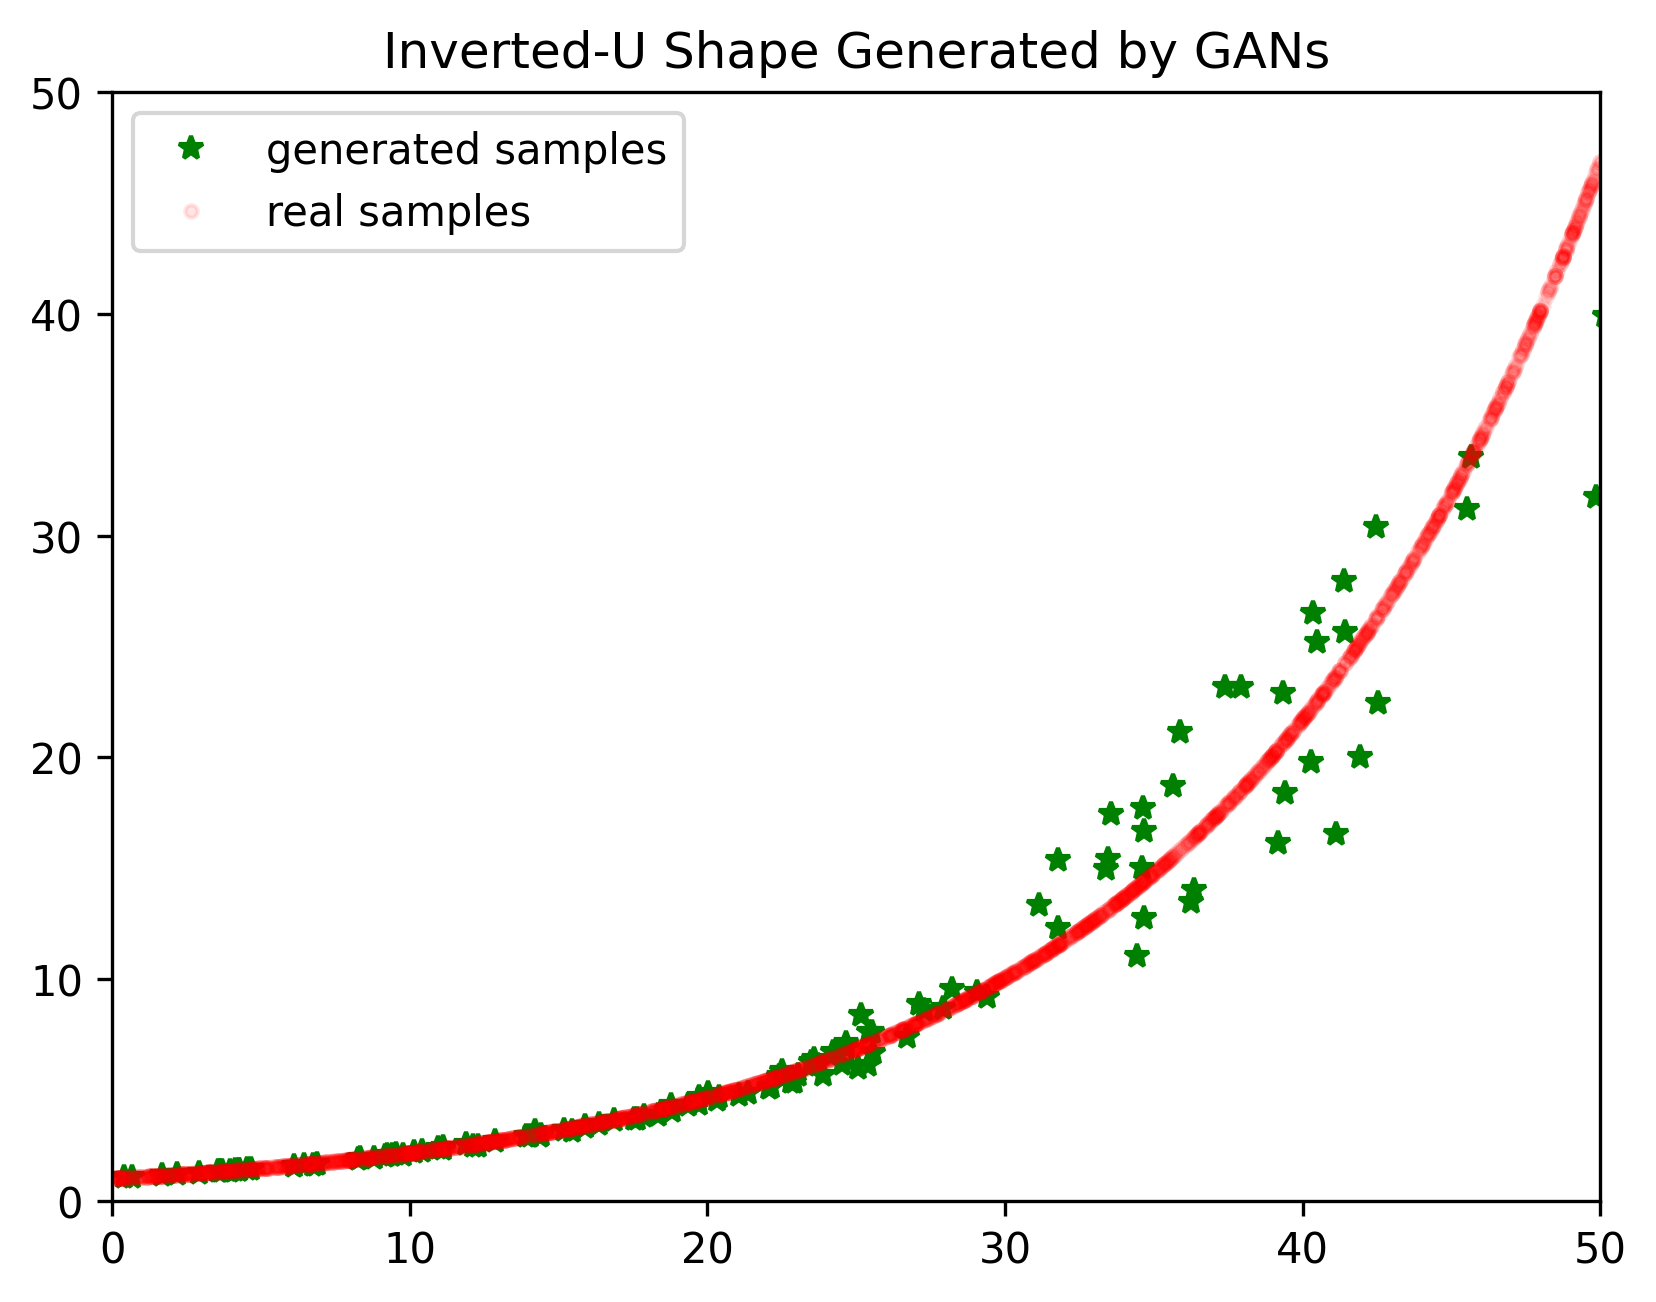

In [19]:
fig=plt.figure(dpi=300)
plt.plot(new_data.detach().cpu().numpy()[:,0],
  new_data.detach().cpu().numpy()[:,1],"*",c="g",
        label="generated samples")    #A
plt.plot(train_data[:,0],train_data[:,1],".",c="r",
         alpha=0.1,label="real samples")    #B
plt.title("Inverted-U Shape Generated by GANs")
plt.xlim(0,50)
plt.ylim(0,50)
plt.legend()
plt.show()

# 4	Generating Numbers with Patterns

## 4.1. What Are One-Hot Variables?

In [20]:
def onehot_encoder(position,depth):
    onehot=torch.zeros((depth,))
    onehot[position]=1
    return onehot

In [21]:
print(onehot_encoder(1,5))

tensor([0., 1., 0., 0., 0.])


In [22]:
def int_to_onehot(number):
    onehot=onehot_encoder(number,100)
    return onehot

In [23]:
onehot75=int_to_onehot(75)
print(onehot75)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [24]:
def onehot_to_int(onehot):
    num=torch.argmax(onehot)
    return num.item()

In [25]:
print(onehot_to_int(onehot75))

75


## 4.2. GANs to Generate Numbers with Patterns 

In [26]:
import random

def gen_sequence():
    indices = random.sample(range(20), 10)
    values = torch.tensor(indices)*5
    return values        

In [27]:
sequence=gen_sequence()
print(sequence)

tensor([60, 85, 25, 90,  5, 40, 80, 50, 15, 55])


In [28]:
import numpy as np

def gen_batch():
    sequence=gen_sequence()    #A
    batch=[int_to_onehot(i).numpy() for i in sequence]    #B
    batch=np.array(batch)
    return torch.tensor(batch)
batch=gen_batch()

In [29]:
def data_to_num(data):
    num=torch.argmax(data,dim=-1)    #A
    return num
numbers=data_to_num(batch)    

In [30]:
D=nn.Sequential(
    nn.Linear(100,1),
    nn.Sigmoid()).to(device)

In [31]:
G=nn.Sequential(
    nn.Linear(100,100),
    nn.ReLU()).to(device)

In [32]:
loss_fn=nn.BCELoss()
lr=0.0005
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

## 4.2. Train the GANs to Generate Numbers with Patterns

In [33]:
real_labels=torch.ones((10,1)).to(device)
fake_labels=torch.zeros((10,1)).to(device)

In [34]:
def train_D_G(D,G,loss_fn,optimD,optimG):
    # Generate examples of real data
    true_data=gen_batch().to(device)
    # use 1 as labels since they are real
    preds=D(true_data)
    loss_D1=loss_fn(preds,real_labels)
    optimD.zero_grad()
    loss_D1.backward()
    optimD.step()
    # train D on fake data
    noise=torch.randn(10,100).to(device)
    generated_data=G(noise)
    # use 0 as labels since they are fake
    preds=D(generated_data)
    loss_D2=loss_fn(preds,fake_labels)
    optimD.zero_grad()
    loss_D2.backward()
    optimD.step()
    
    # train G 
    noise=torch.randn(10,100).to(device)
    generated_data=G(noise)
    # use 1 as labels since G wants to fool D
    preds=D(generated_data)
    loss_G=loss_fn(preds,real_labels)
    optimG.zero_grad()
    loss_G.backward()
    optimG.step()
    return generated_data       

In [35]:
stopper=EarlyStop(800)    #A

mse=nn.MSELoss()
def distance(generated_data):    #B
    nums=data_to_num(generated_data)
    remainders=nums%5
    ten_zeros=torch.zeros((10,1)).to(device)
    mseloss=mse(remainders,ten_zeros)
    return mseloss

for i in range(10000):
    gloss=0
    dloss=0
    generated_data=train_D_G(D,G,loss_fn,optimD,optimG)    #C  
    dis=distance(generated_data)
    if stopper.stop(dis)==True:
        break   
    if i % 50 == 0:
        print(data_to_num(generated_data))    #D

C:\Users\hlliu2\Anaconda3\envs\nlp\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([75, 93, 31, 79, 53, 49, 89, 74, 35, 95], device='cuda:0')
tensor([ 6,  9, 19, 89,  9, 73, 30, 47,  0, 20], device='cuda:0')
tensor([91, 35, 36,  9, 89, 75, 53, 85, 18, 18], device='cuda:0')
tensor([58, 78, 60, 92,  2, 67, 80, 79, 92, 85], device='cuda:0')
tensor([79, 53, 36, 80, 48, 75, 92, 52, 65, 18], device='cuda:0')
tensor([48, 92, 99, 85, 56, 68, 68, 67, 99, 85], device='cuda:0')
tensor([88, 78, 80, 73, 85, 35, 85, 52, 75, 35], device='cuda:0')
tensor([92, 46, 46, 92, 76, 48, 52, 46, 22, 92], device='cuda:0')
tensor([91, 68, 76, 73, 92, 53, 80, 52, 22, 68], device='cuda:0')
tensor([18, 46, 92, 80, 35, 85, 67, 18, 53, 76], device='cuda:0')
tensor([48, 92, 68, 76, 92, 95, 80, 75, 78,  5], device='cuda:0')
tensor([40, 76, 90, 80, 75, 50, 99, 90, 75, 48], device='cuda:0')
tensor([90, 90, 25, 40, 80,  5, 92, 30, 67, 76], device='cuda:0')
tensor([30, 67, 25, 35, 25,  5, 70, 25, 25, 80], device='cuda:0')
tensor([15, 40, 53, 40,  5, 90, 25, 90, 15, 40], device='cuda:0')
tensor([60

## 5.4. Save and Use the Trained Model

In [36]:
# Export to TorchScript
scripted = torch.jit.script(G) 

scripted.save('files/num_gen.pt') 

In [37]:
new_G=torch.jit.load('files/num_gen.pt',
                     map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
)

In [38]:
# obtain inputs from the latent space
torch.manual_seed(42)
noise=torch.randn((10,100)).to(device)
# feed the input to the generator 
new_data=new_G(noise) 
print(data_to_num(new_data))

tensor([60,  5, 15, 20, 15, 15, 20, 20, 20, 60], device='cuda:0')
